In [44]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import numpy.linalg as linalg
import time
import math as m
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels as stats
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import ccf
from seasonal import fit_seasons, adjust_seasons
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid

In [45]:
#FUNCIÓN PARA HACER LA CORRELACIÓN ESPACIAL, ES DECIR UN ÍNDICE CON UN MAPA,
#AUNQUE PODRÍA SER TAMBIÉN ENTRE DOS INDICES PARA n1=1
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #los datos introducidos en Data tienen que tener dimesión n1=espacio, n2=tiempo 
    #inicializamos las matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #para cada punto del espacio hacemos la correlación de Pearson
        bb=pearsonr(Data[nn,:],Index) #bb tiene dos salidas: la primera es corre y la segunda es p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #generamos una variable que es para que no se muestren mas que los valores de Cor cuando la correlacion
    #es significativa
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    #generamos el mapa de regresión mediante multiplicación matricial. Ojo con las dimensiones!!
    reg=Data.dot(Index)/ (n2-1)
    #igualmente, hacemos una máscara para que sólo se muestre el mapa de regresión cuando es significativo
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_sig

In [46]:
fil=nc.Dataset('SST_era5_1979_2020_remallado.nc')
#fil.variables

fil.variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     standard_name: time
     long_name: time
     units: hours since 1900-01-01 00:00:00.0
     calendar: gregorian
     axis: T
 unlimited dimensions: time
 current shape = (500,)
 filling on, default _FillValue of -2147483647 used,
 'lon': <class 'netCDF4._netCDF4.Variable'>
 float64 lon(lon)
     standard_name: longitude
     long_name: longitude
     units: degrees_east
     axis: X
 unlimited dimensions: 
 current shape = (181,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float64 lat(lat)
     standard_name: latitude
     long_name: latitude
     units: degrees_north
     axis: Y
 unlimited dimensions: 
 current shape = (91,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'expver': <class 'netCDF4._netCDF4.Variable'>
 float64 expver(expver)
     long_name: expver
     axis: Z
 unlimited dimensions: 
 current shape = (2,)
 filling on, defa

In [47]:
lat=fil.variables['lat'][:]
lon=fil.variables['lon'][:]
SST = fil.variables['sst'][:]
SST.shape

(500, 2, 91, 181)

In [48]:
#Como tenemos que utilizar años completos, hay que eliminar los últimos 8 datos de sst correspondientes a enero-agosto de 2020
nt, nexpver, nlat, nlon = SST.shape
SST=SST[:-8,0,:,:]
SST=np.squeeze(SST)
SST.shape

(492, 91, 181)

In [49]:
nm = 12
nyears = int(nt/nm)

In [50]:
# Esta celda y las dos siguientes son una prueba para ver si el detrended lo hace bien
SST=SST.reshape(nyears,nm,nlat*nlon)
SST1=SST.mean(2)
SST1.shape


(41, 12)

<ipython-input-51-4c0b10b06787>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')


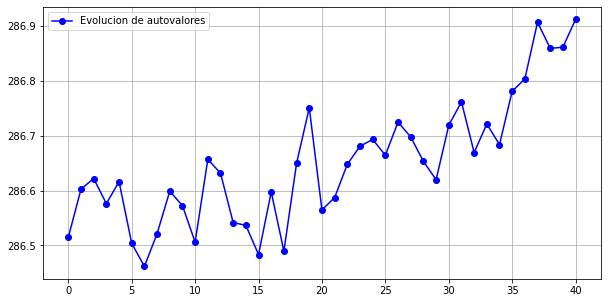

In [51]:
# dibujo la media espacial de eneros sin quitar la tendencia
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

<ipython-input-52-b2cab52461e3>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1d[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')


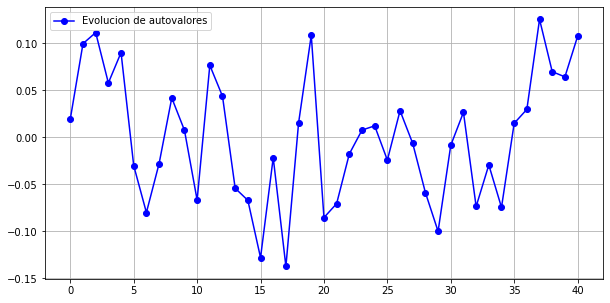

In [52]:
# dibujo la media espacial de eneros al quitar la tendencia
SST1d=signal.detrend(SST1,axis=0)
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1d[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

<ipython-input-53-b8346490b1d9>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1d[:,4]-SST1[:,4],color='Blue',Marker='o')


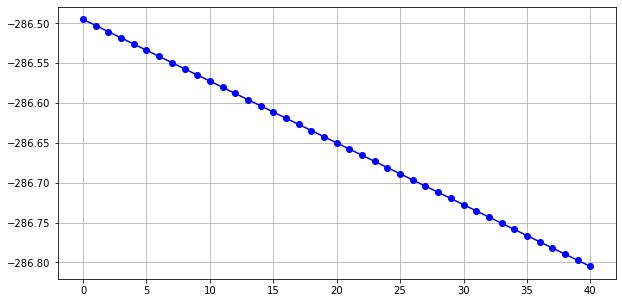

In [53]:
# dibujo la diferencia media espacial de un mes dado al quitar la tendencia
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1d[:,4]-SST1[:,4],color='Blue',Marker='o')
plt.grid()

In [54]:
#SST[:,0,0]=signal.detrend(SST[:,0,0])
#SST[:,0,0]
SST=SST.reshape(nyears,nm,nlat*nlon)
SST=signal.detrend(SST,axis=0)

In [55]:
SST=SST.reshape(nyears*nm,nlat,nlon)
SST.shape

(492, 91, 181)

In [56]:

lonmin,lonmax,latmin,latmax = -50, 20, -20, 20
AT = SST[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
yrs = np.arange(1979,2020)
lon_AT= lon[(lon>lonmin)&(lon<lonmax)]
lat_AT=lat[(lat>latmin)&(lat<latmax)]


In [57]:
nt,nlat2,nlon2=AT.shape

In [58]:
AT=AT.reshape(nyears, nm, nlat2,nlon2)


In [59]:
AT_e=AT.reshape(nyears,nm,nlat2*nlon2)[:,[0],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_e=(AT_e-AT_e.mean(0))
AT_e.shape
AT_f=AT.reshape(nyears,nm,nlat2*nlon2)[:,[1],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_f=(AT_f-AT_f.mean(0))
AT_f.shape

AT_m=AT.reshape(nyears,nm,nlat2*nlon2)[:,[2],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_m=(AT_m-AT_m.mean(0))
AT_m.shape

AT_a=AT.reshape(nyears,nm,nlat2*nlon2)[:,[3],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_a=(AT_a-AT_a.mean(0))
AT_a.shape

AT_y=AT.reshape(nyears,nm,nlat2*nlon2)[:,[4],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_y=(AT_y-AT_y.mean(0))
AT_y.shape

AT_j=AT.reshape(nyears,nm,nlat2*nlon2)[:,[5],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_j=(AT_j-AT_j.mean(0))
AT_j.shape

AT_l=AT.reshape(nyears,nm,nlat2*nlon2)[:,[6],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_l=(AT_l-AT_l.mean(0))
AT_l.shape

AT_u=AT.reshape(nyears,nm,nlat2*nlon2)[:,[7],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_u=(AT_u-AT_u.mean(0))
AT_u.shape

AT_s=AT.reshape(nyears,nm,nlat2*nlon2)[:,[8],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_s=(AT_s-AT_s.mean(0))
AT_s.shape

AT_o=AT.reshape(nyears,nm,nlat2*nlon2)[:,[9],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_o=(AT_o-AT_o.mean(0))
AT_o.shape

AT_n=AT.reshape(nyears,nm,nlat2*nlon2)[:,[10],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_n=(AT_n-AT_n.mean(0))
AT_n.shape

AT_d=AT.reshape(nyears,nm,nlat2*nlon2)[:,[11],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_d=(AT_d-AT_d.mean(0))
AT_d.shape
AT_inv=[]
AT_pri=[]
AT_ver=[]
AT_oto=[]
for i in range (nyears-1):
    AT_inv=np.concatenate([AT_inv,AT_d[i,],AT_e[i+1,],AT_f[i+1,]])                     
    AT_pri=np.concatenate([AT_pri,AT_m[i+1,],AT_a[i+1,],AT_y[i+1,]])
    AT_ver=np.concatenate([AT_ver,AT_j[i+1,],AT_l[i+1,],AT_u[i+1,]])
    AT_oto=np.concatenate([AT_oto,AT_s[i+1,],AT_o[i+1,],AT_n[i+1,]])

In [60]:
AT_oto

array([ 6.56610809e-12,  6.56610809e-12,  6.56610809e-12, ...,
       -7.98580714e-12, -7.98580714e-12, -7.98580714e-12])

In [61]:
##AQUÍ PUEDO SELECCIONAR UNA ESTACIÓN Y TRANSFORMARLA EN AT##

In [62]:
AT=AT.reshape(nyears*nm,nlat2*nlon2)
AT_ver=AT_ver.reshape(40*3,nlat2*nlon2)
AT_pri=AT_pri.reshape(40*3,nlat2*nlon2)
AT_inv=AT_inv.reshape(40*3,nlat2*nlon2)
AT_oto=AT_oto.reshape(40*3,nlat2*nlon2)

AT.shape

(492, 700)

In [63]:
C=np.dot(np.transpose(AT),AT)
C.shape

(700, 700)

In [64]:
eof,d,eof2=linalg.svd(C)
d.shape
fvar=(d)/sum(d)

sum(fvar[:2])

0.5677298600414376

<ipython-input-65-a7b4fd9fe7b6>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')


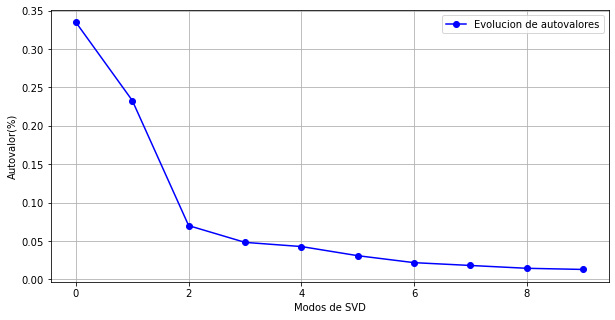

In [65]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.xlabel('Modos de SVD')
plt.ylabel('Autovalor(%)')
plt.legend()
plt.grid()

In [66]:
#Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así 
#que no se transpone
PC=np.dot(AT,eof[:,:5])
AT
#calculamos las anomalías estandarizadas 

array([[ 3.63797881e-12,  3.63797881e-12,  3.63797881e-12, ...,
         3.63797881e-12,  3.63797881e-12,  3.63797881e-12],
       [ 3.63797881e-12,  3.63797881e-12,  3.63797881e-12, ...,
         3.63797881e-12,  3.63797881e-12,  3.63797881e-12],
       [ 3.63797881e-12,  3.63797881e-12,  3.63797881e-12, ...,
         3.63797881e-12,  3.63797881e-12,  3.63797881e-12],
       ...,
       [-1.09139364e-11, -1.09139364e-11, -1.09139364e-11, ...,
        -1.09139364e-11, -1.09139364e-11, -1.09139364e-11],
       [-1.09139364e-11, -1.09139364e-11, -1.09139364e-11, ...,
        -1.09139364e-11, -1.09139364e-11, -1.09139364e-11],
       [-1.09139364e-11, -1.09139364e-11, -1.09139364e-11, ...,
        -1.09139364e-11, -1.09139364e-11, -1.09139364e-11]])

In [67]:
#PC=PC.reshape(nyears*nm,5)

In [68]:
PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs

array([[-0.28377084, -0.40687425, -0.41626089,  0.27485288,  0.50519044],
       [-0.36121828, -1.41509476,  0.0578017 , -0.29863524,  0.41601647],
       [-0.49501449, -0.60158795, -0.10745645, -0.46356559, -0.6800937 ],
       ...,
       [ 0.89309542,  0.93340075, -0.29110342,  0.87199024,  0.69334867],
       [ 2.17192169,  1.34808754,  0.22504614,  0.16800083, -0.10197406],
       [ 2.34391973,  1.55334393, -0.04336007, -1.24395587, -0.26084793]])

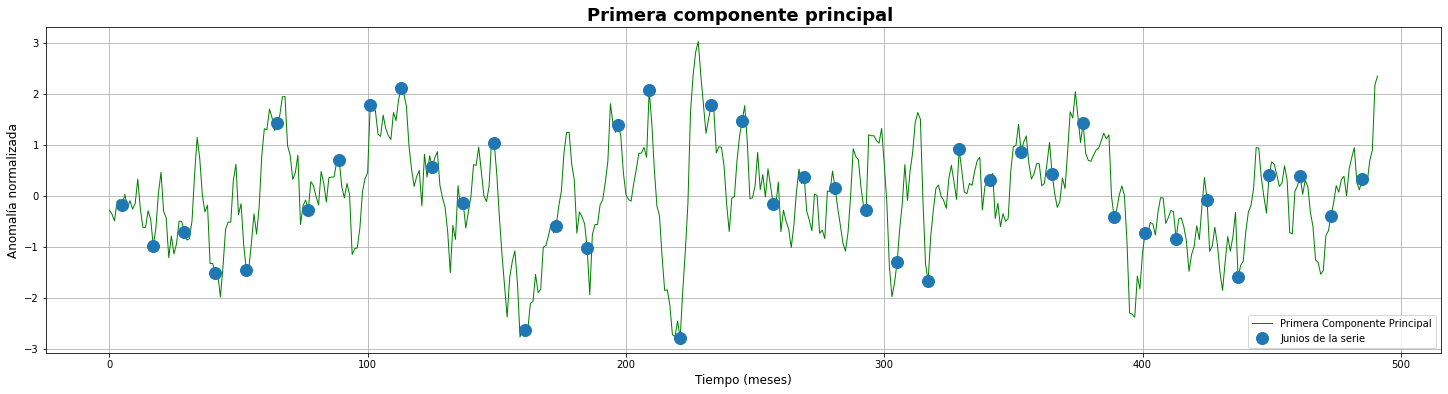

In [69]:
PCp=PCs.reshape(nyears*nm,5)
fig,ax=plt.subplots(figsize = (25,6))
ax.plot(np.arange(nt),PCp[:,0],linewidth= 1,color='green',label='Primera Componente Principal')
ax.plot(np.arange(5,nt,nm),PCp[np.arange(5,nt,nm),0],linewidth= 0,marker='o',markersize=12,label='Junios de la serie') #marco todos los junios de la serie
ax.grid()
ax.legend(loc='lower right')
ax.set_title('Primera componente principal ',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)
fig.savefig('C:/Users/Miguel/TFG/fotostfg/ECAZM.png')

In [70]:
# para ver la máxima variabilidad se calcula la desviación estandar de cada mes:

PC_var=PCs.reshape(nyears,nm,5).std(0)

In [71]:
PC_var.shape

(12, 5)

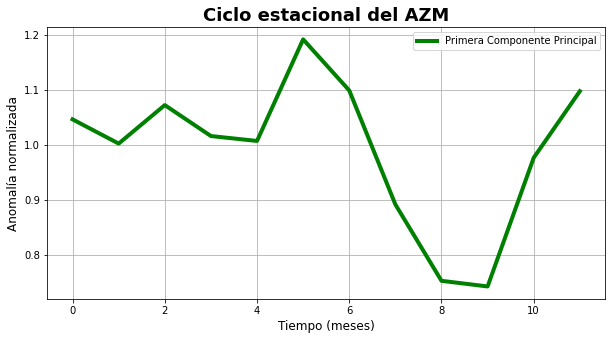

In [72]:
#Estaría calculando la serie temporal del ciclo estacional para el modo 1
PCpinto=np.squeeze(PC_var[:,0])
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(np.arange(nm),PCpinto,linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Ciclo estacional del AZM',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)
fig.savefig('C:/Users/Miguel/TFG/fotostfg/estacionalazm.png')

Text(0, 0.5, 'Anomalía normalizada')

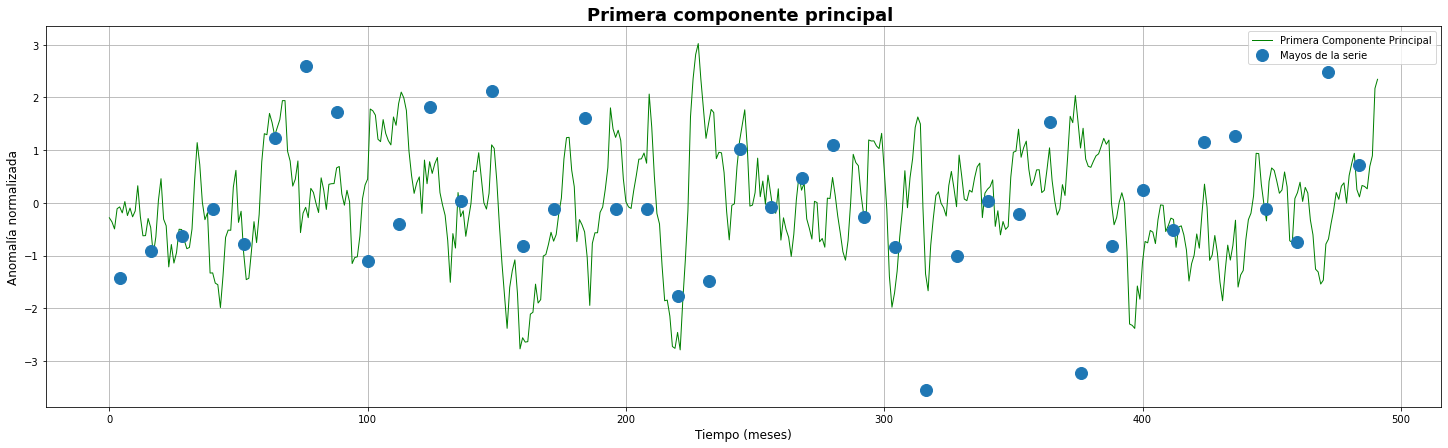

In [73]:
PCs=PCs.reshape(nyears*nm,5)
fig,ax=plt.subplots(figsize = (25,7))
ax.plot(np.arange(nt),PCs[:,0],linewidth= 1,color='green',label='Primera Componente Principal')
ax.plot(np.arange(4,nt,nm),PCp[np.arange(4,nt,nm),1],linewidth= 0,marker='o',markersize=12,label='Mayos de la serie') #marco todos los mayos de la serie
ax.grid()
ax.legend()
ax.set_title('Primera componente principal ',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)

In [74]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,0]),0.01)

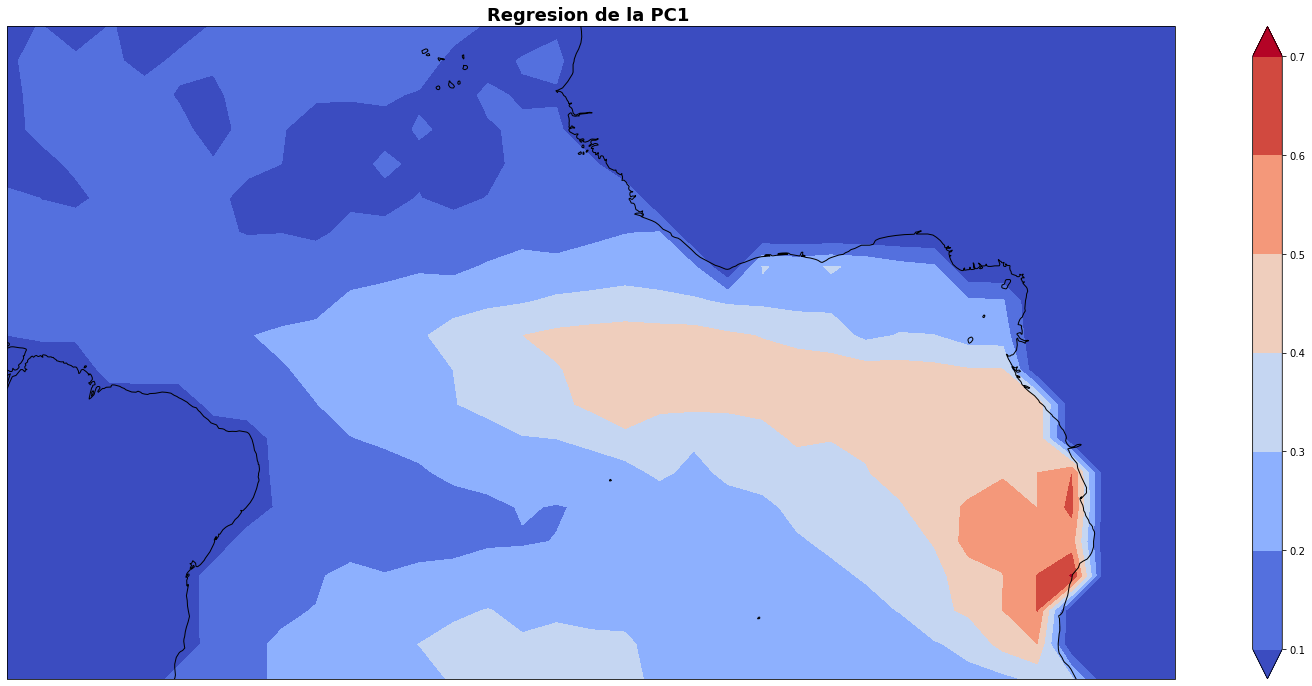

In [75]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la PC1 ',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/EZM.png')

Text(0.5, 1.0, 'Mapa de Correlación de la EC1 ')

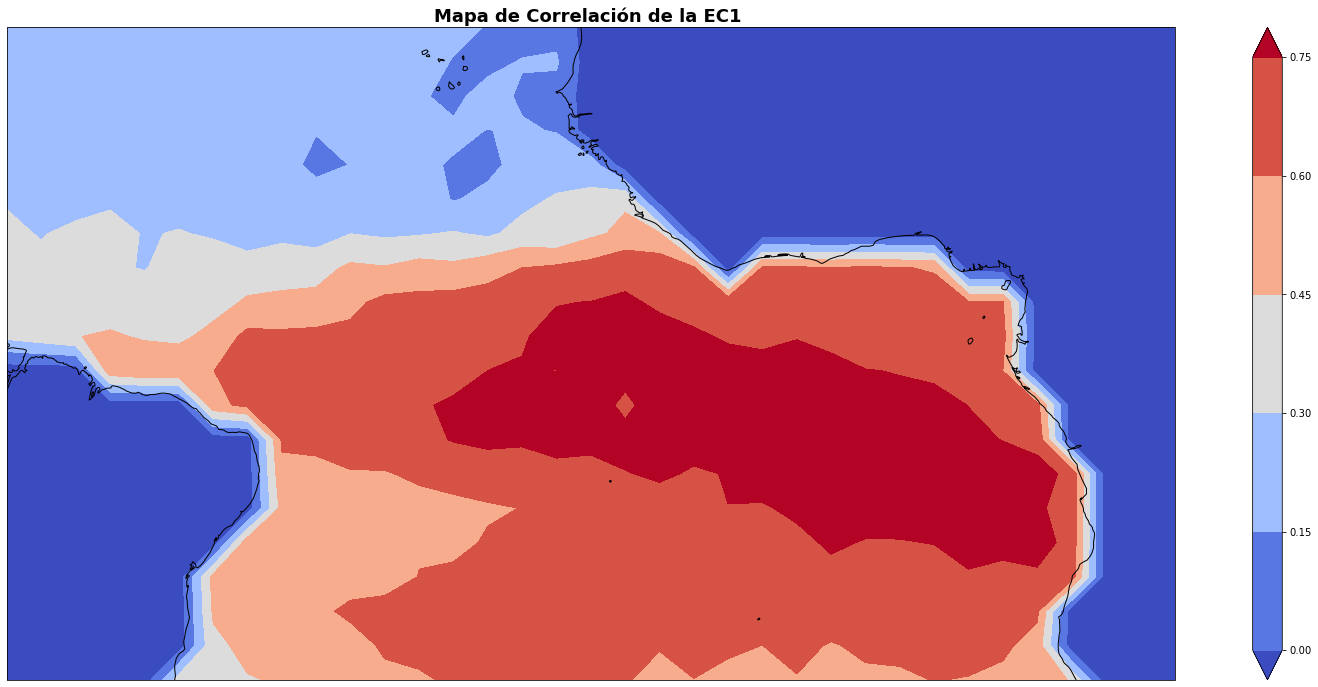

In [76]:

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Mapa de Correlación de la EC1 ',fontsize=18,weight='bold')


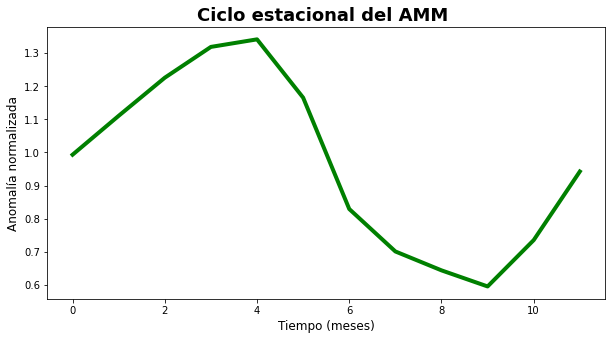

In [77]:
#Estaría calculando la serie temporal del ciclo estacional para el modo 2
PCpinto=np.squeeze(PC_var[:,1])
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(np.arange(nm),PCpinto,linewidth= 4,color='green',label='Primera Componente Principal')
ax.set_title('Ciclo estacional del AMM ',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)
fig.savefig('C:/Users/Miguel/TFG/fotostfg/estacionalAMM.png')


In [78]:
PC2s=PCs.reshape(nyears,nm,5)[:,:,1].mean(0)
PC2s

array([ 2.00138009e-14,  7.06413248e-16, -7.35725843e-15,  1.37694734e-14,
       -5.71358679e-16,  1.17954427e-14, -1.20201951e-14, -9.26630046e-15,
       -3.44575317e-15, -1.28081827e-15, -7.72823540e-15, -4.08345444e-15])

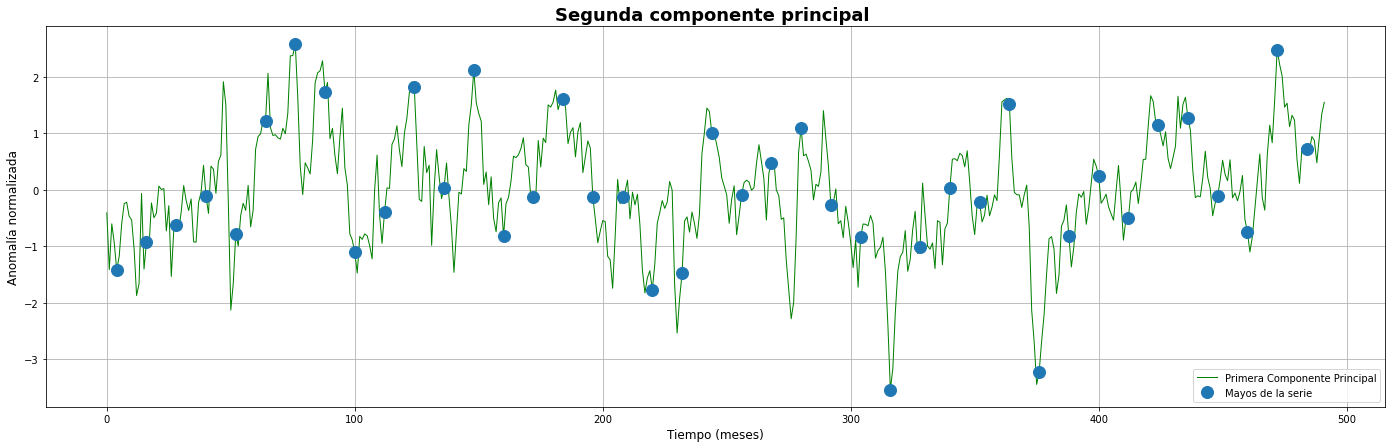

In [79]:
PCp=PCs.reshape(nyears*nm,5)
fig,ax=plt.subplots(figsize = (24,7))
ax.plot(np.arange(nt),PCp[:,1],linewidth= 1,color='green',label='Primera Componente Principal')
ax.plot(np.arange(4,nt,nm),PCp[np.arange(4,nt,nm),1],linewidth= 0,marker='o',markersize=12,label='Mayos de la serie') #marco todos los mayos de la serie
#marco todos los septiembres de la serie

ax.grid()
ax.legend(loc='lower right')
ax.set_title('Segunda componente principal ',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)
fig.savefig('C:/Users/Miguel/TFG/fotostfg/ECAMM.png')

In [80]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,1]),0.01)

Text(0.5, 1.0, 'Mapa Regresion de la EC2 ')

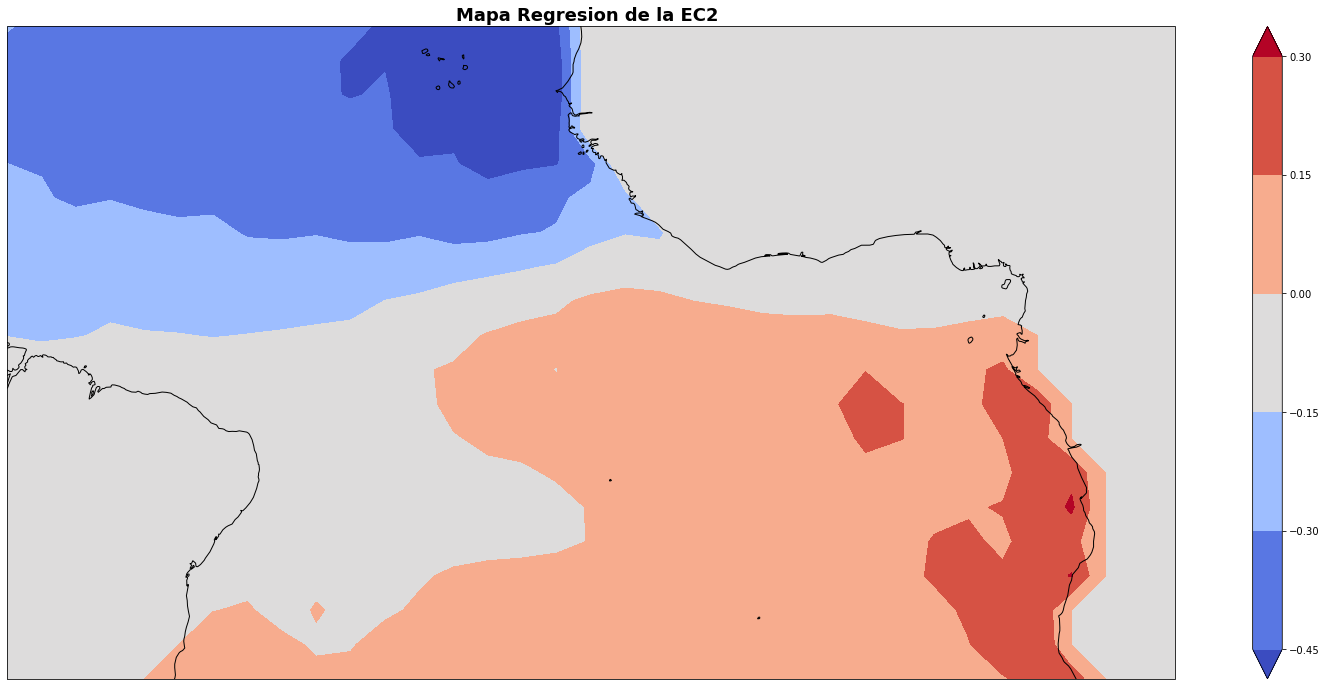

In [81]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Mapa Regresion de la EC2 ',fontsize=18,weight='bold')

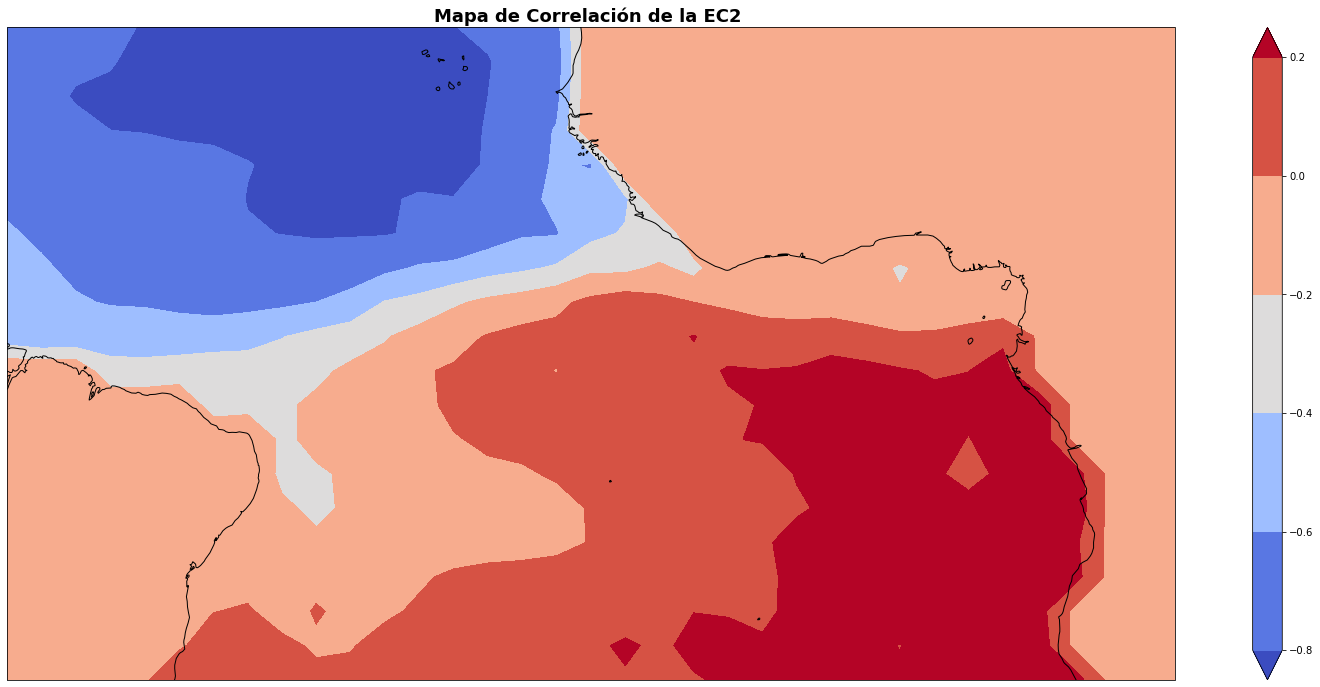

In [82]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Mapa de Correlación de la EC2 ',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/AMM.png')

In [83]:
PC3s=PCs.reshape(nyears,nm,5)[:,:,2].mean(0)
PC3s.shape

(12,)

Text(0, 0.5, 'Anomalía normalizada')

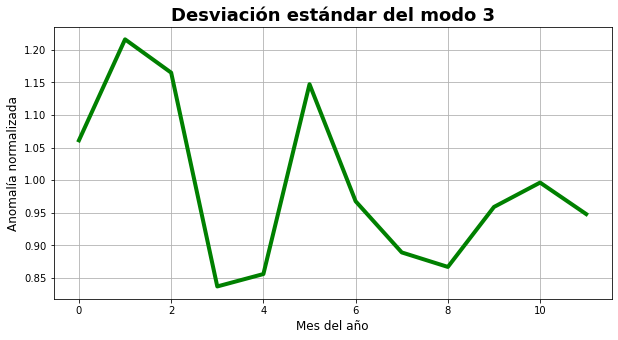

In [84]:
#Estaría calculando la serie temporal del ciclo estacional para el modo 1
PCpinto=np.squeeze(PC_var[:,2])
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(np.arange(nm),PCpinto,linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.set_title('Desviación estándar del modo 3',fontsize=18,weight='bold')
ax.set_xlabel('Mes del año',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)

Text(0, 0.5, 'Anomalía normalizada')

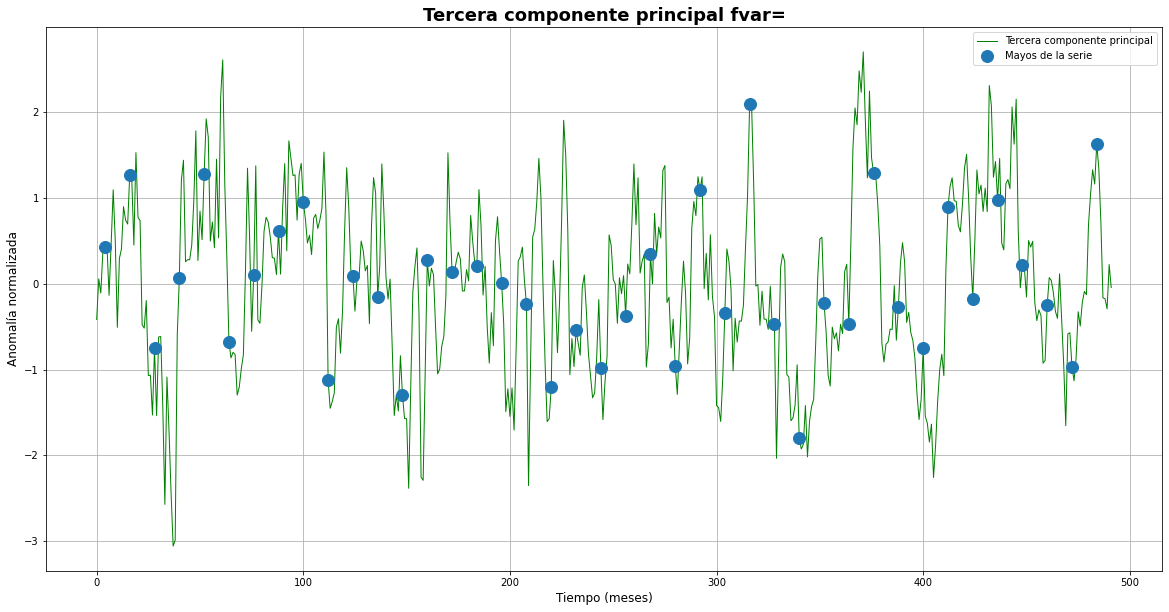

In [85]:
fig,ax=plt.subplots(figsize = (20,10))
ax.plot(range(nt),PCs[:,2],linewidth= 1,color='green',label='Tercera componente principal')
ax.plot(np.arange(4,nt,nm),PCp[np.arange(4,nt,nm),2],linewidth= 0,marker='o',markersize=12,label='Mayos de la serie')
#marco todos los mayos de la serie
ax.grid()
ax.legend()
ax.set_title('Tercera componente principal fvar=',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)

Text(0.5, 1.0, 'NIÑO ATLÁNTICO')

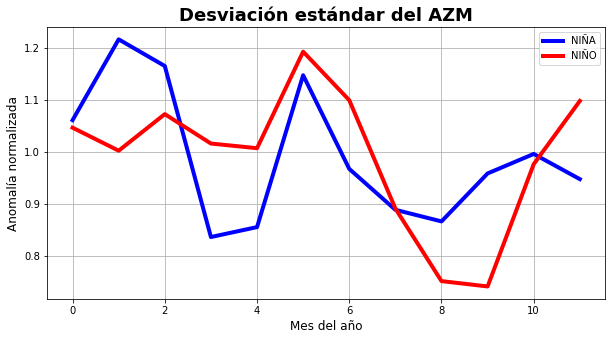

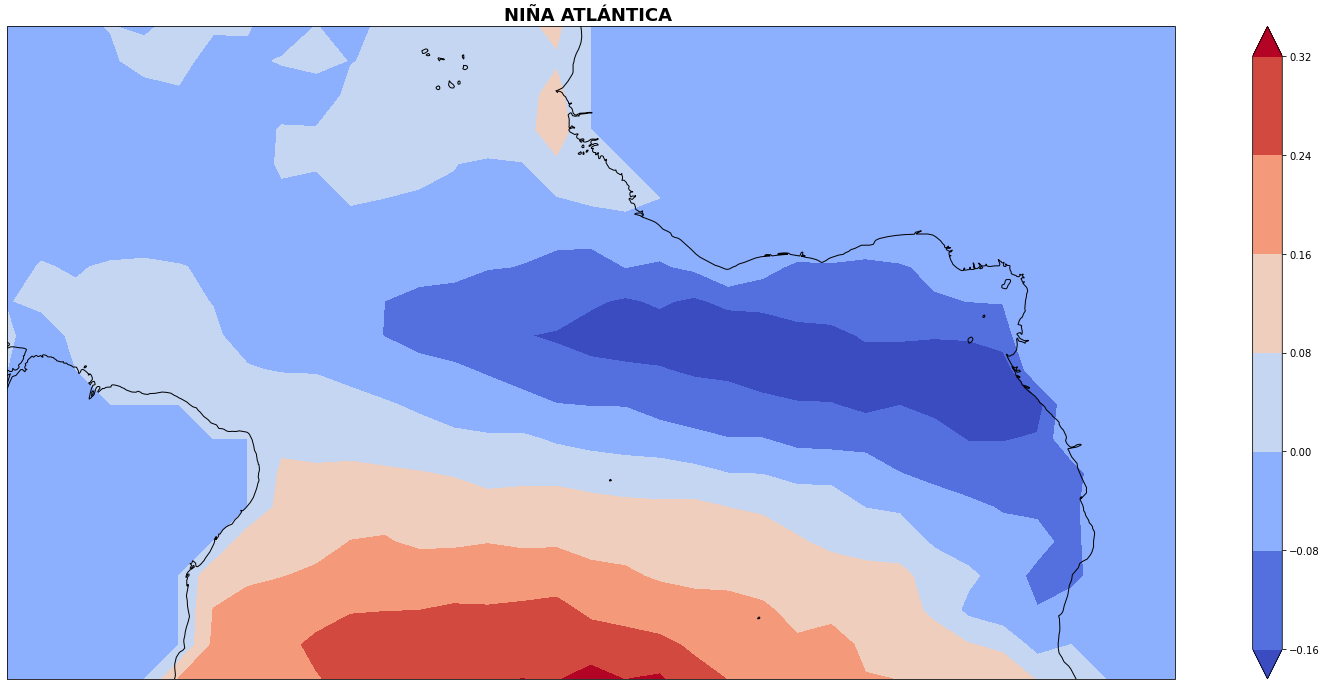

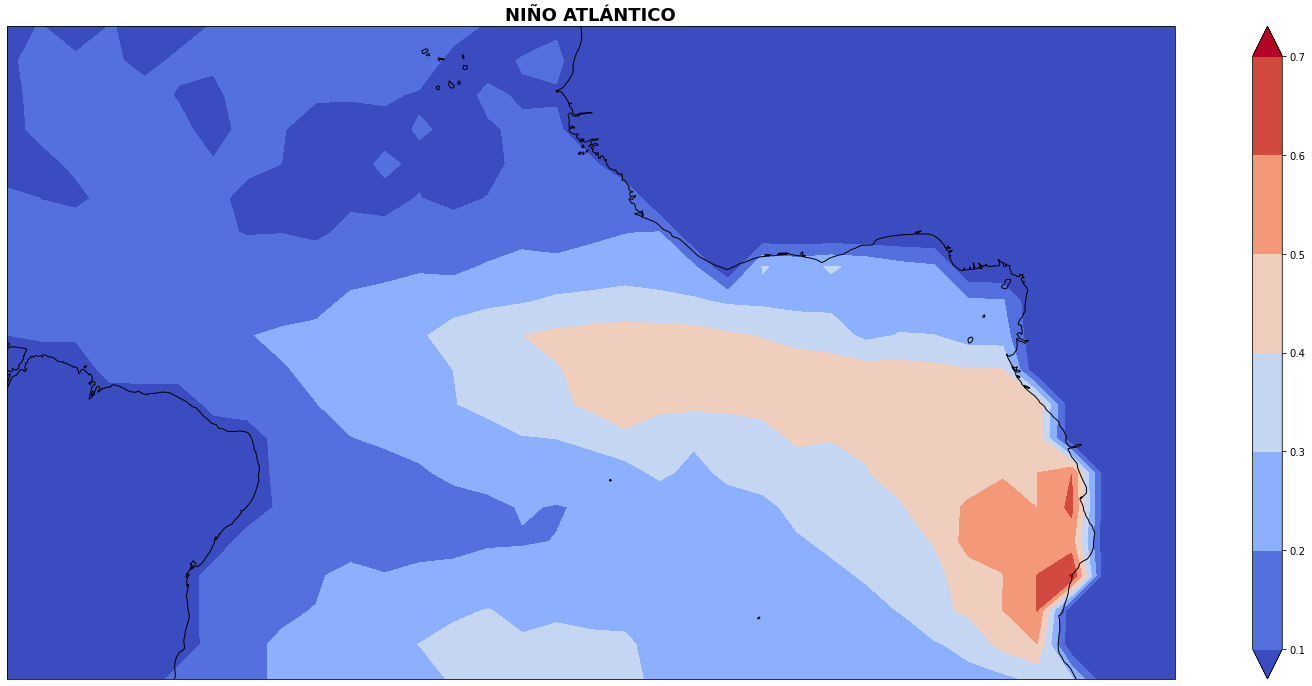

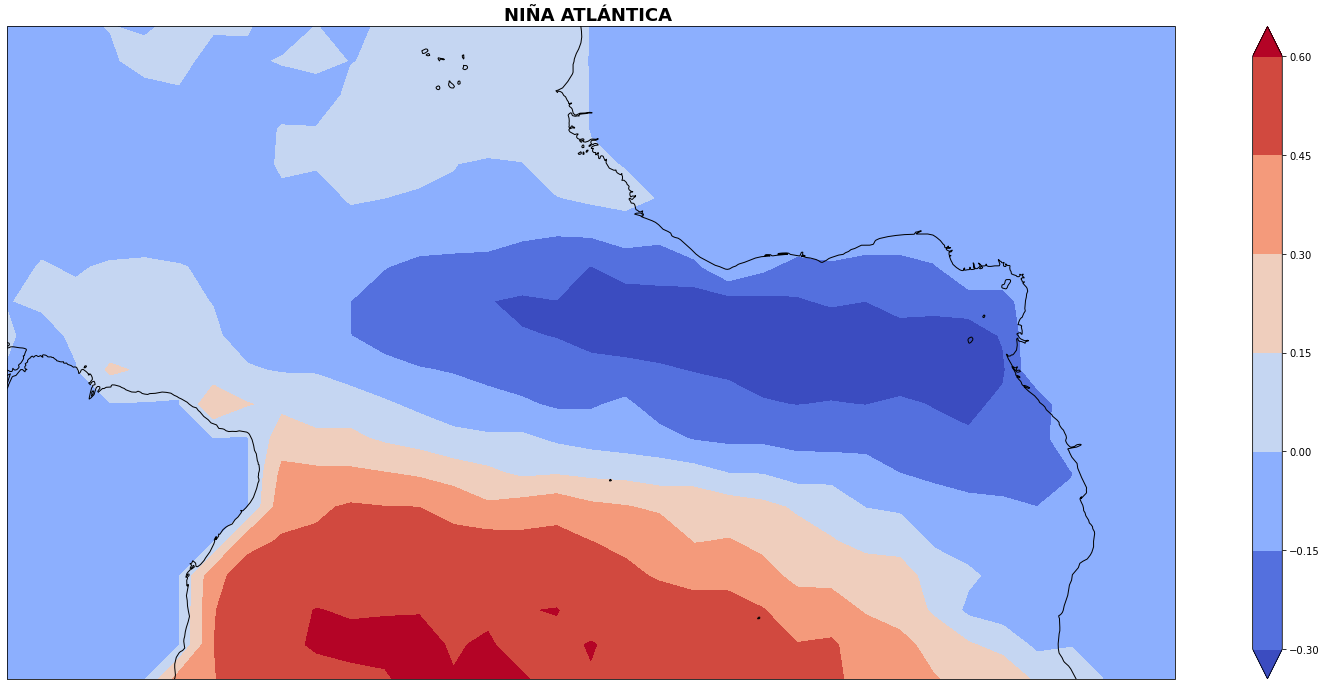

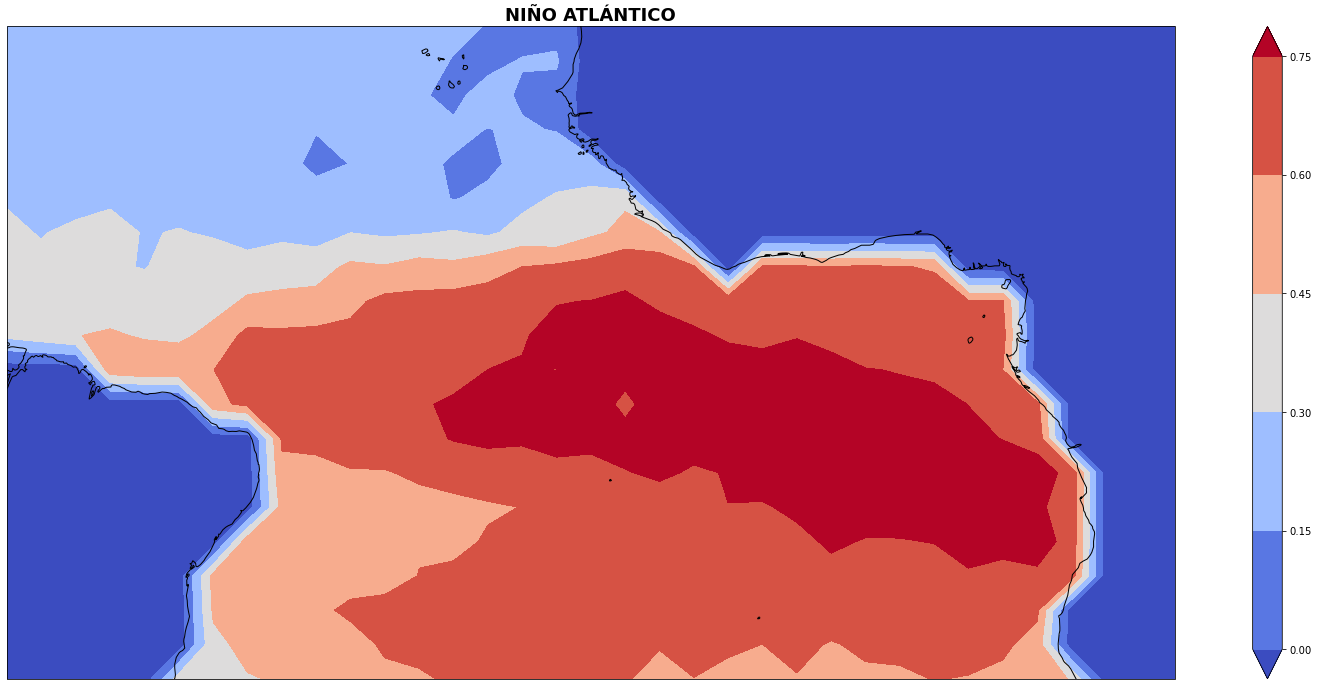

In [86]:
#Estaría calculando la serie temporal del ciclo estacional para el modo 1
PCpinto2=np.squeeze(PC_var[:,2])
PCpinto=np.squeeze(PC_var[:,0])
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(np.arange(nm),PCpinto2,linewidth= 4,color='blue',label='NIÑA')
ax.plot(np.arange(nm),PCpinto,linewidth= 4,color='red',label='NIÑO')
ax.grid()
ax.legend()
ax.set_title('Desviación estándar del AZM',fontsize=18,weight='bold')
ax.set_xlabel('Mes del año',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)



CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,2]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('NIÑA ATLÁNTICA ',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,0]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('NIÑO ATLÁNTICO',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,2]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('NIÑA ATLÁNTICA ',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,0]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('NIÑO ATLÁNTICO',fontsize=18,weight='bold')


Text(0.5, 1.0, 'Regresion de la AMM ')

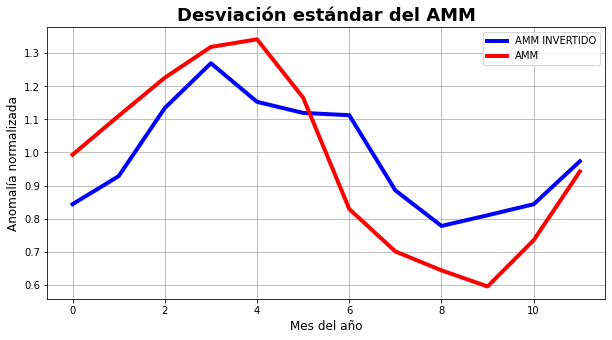

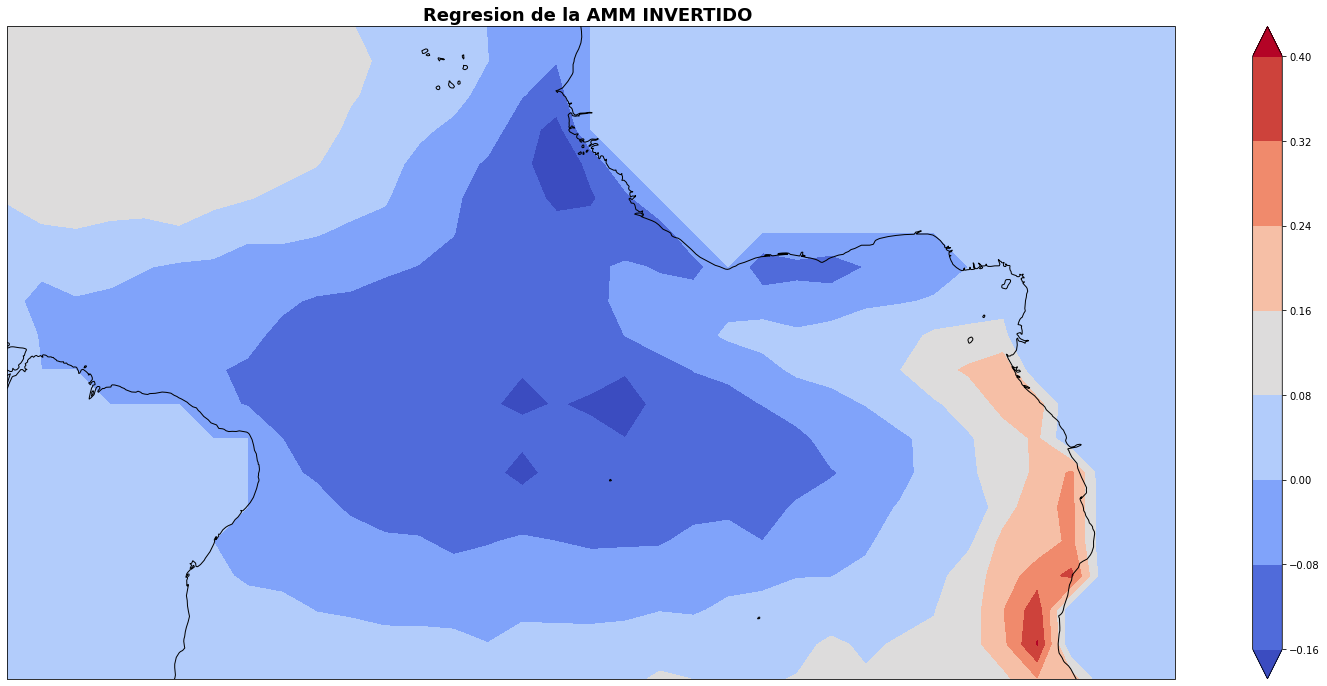

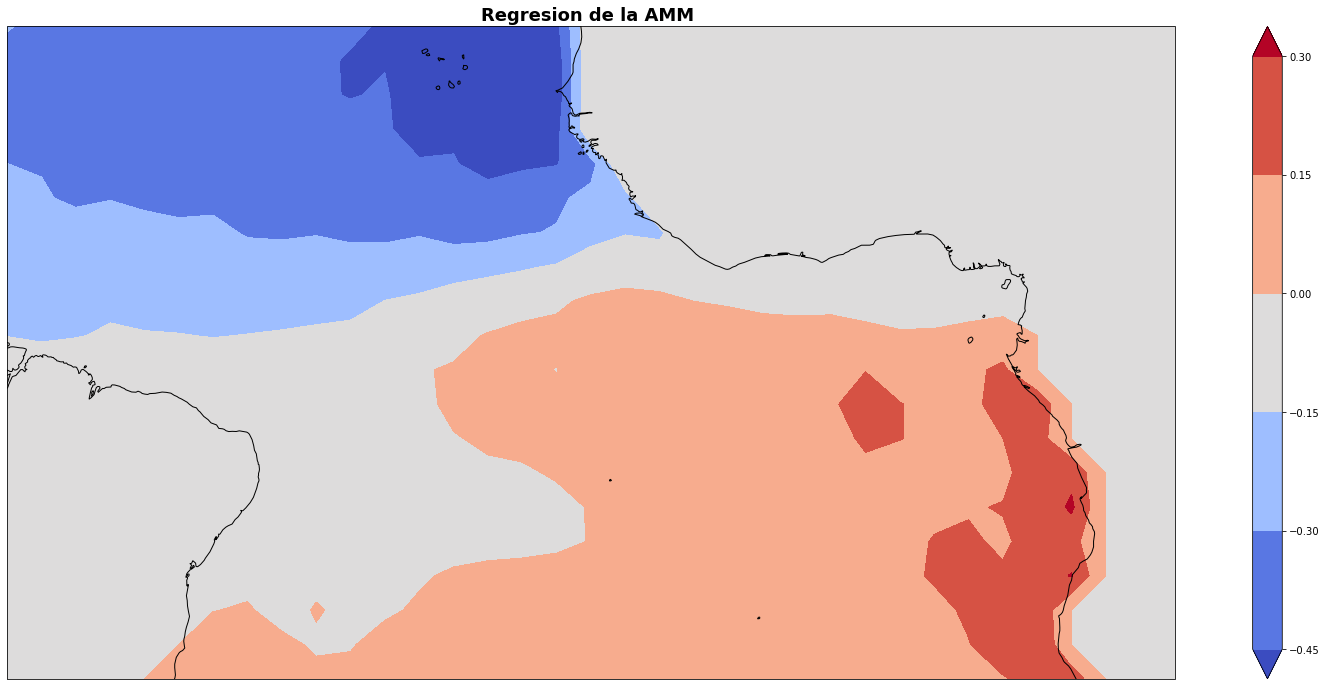

In [87]:
PC4s=PCs.reshape(nyears,nm,5)[:,:,3].mean(0)
PC4s.shape

#Estaría calculando la serie temporal del ciclo estacional para el modo 1
PCpinto2=np.squeeze(PC_var[:,3])
PCpinto=np.squeeze(PC_var[:,1])
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(np.arange(nm),PCpinto2,linewidth= 4,color='blue',label='AMM INVERTIDO')
ax.plot(np.arange(nm),PCpinto,linewidth= 4,color='red',label='AMM')
ax.grid()
ax.legend()
ax.set_title('Desviación estándar del AMM',fontsize=18,weight='bold')
ax.set_xlabel('Mes del año',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)



CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,3]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la AMM INVERTIDO ',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,1]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la AMM ',fontsize=18,weight='bold')



In [88]:
#APUNTES BREVES
    ##NO ESTOY SEGURO DE ESTAR REALIZANDO CORRECTAMENTE EL DETREND DE LA SEÑAL, LA REALIZO EN LA COLUMNA SST
    ##CORRESPONDIENTE A LOS DATOS DE TEMPERATURA
    
    ## LOS MAPAS DE REGRESIÓN LOS DIBUJO CON TODOS LOS DATOS POR AÑO, APARECIENDO UN 
    ## ERROR SIMILAR AL QUE OCURRE CUANDO UTILIZO DATOS ESTACIONALES (TRIMESTRALES); QUE DIBUJA LAS ANOMALÍAS 
    ## EN TODO EL MAPA INCLUIDA PARTE CONTINENTAL

    ## HE SEGUIDO TUS DIRECTRICES PARA LAS PC, Y POR CADA MODO HALLO LO QUE CREO QUE ES UN AVERAGE DEL CICLO ESTACIONAL
    ## ANUAL Y LUEGO LA SERIE TEMPORAL COMPLETA CON EL EJE DE ABSCISAS EN EL NÚMERO DE MESES TOTALES (LUEGO BUSCO COMO
    ## INTRODUCIR UN EJE ANUAL PARA VISUALIZARSE MEJOR)
    
    ## NO ESTOY SEGURO DEL CORRECTO FUNCIONAMIENTO DE TODAS LAS PARTES DEL CÓDIGO AUNQUE PARECE QUE SI QUE TIRA 
    ## PARA VISUALIZAR LOS MAPAS DE REGRESIÓN POR MESES BASTA CON INTRODUCIR LA AT_ CORRESPONDIENTE
    ##(AT_s PARA SEPTIEMBRE) Y L PC DEL MES (PCi en este caso, indicando el modo deseado)
    ## HE DEJADO EL TERCER MODO DE EOF SIMPLEMENTE PORQUE PARECE QUE SE CENTRA EN ANGOLA BENGUELA Y EL ANTICICLÓN DEL 
    ##ATLÁNTICO SUR.
    
    ##VOY A SEGUIR PROBANDO DISTINTAS COMBINACIONES, SOLO MESES Y ESTACIONALES A VER SI COMPRENDO BIEN LOS FENÓMENOS
    
    
    
    

In [89]:
#MÉTODO DE ANOMALÍAS SIGNIFICATIVAS PARA ESTUDIAR CLOROFILA

In [90]:
  #Comienzo calculando las anomalías positivas y negativas, y separándolas

In [91]:
POS=PCp[:,0][PCp[:,0]>0]
POS.shape

(248,)

In [92]:
NEG=PCp[:,0][PCp[:,0]<0]
NEG.shape

(244,)

In [93]:
  #La suma de ambos arrays da como resultado la dimensión oriiginal de la componente temporal 492  BIEEN

In [94]:
# Hallo las desviaciones estándar de ambos grupos

In [95]:
np.std(POS)

0.592345409992388

In [96]:
-np.std(NEG)

-0.6620071145266441

In [97]:
#Selecciono solo los valores que superen el valor de la std correspondiente, y visualizo sus índices


#ESO SÍ, EN ESTE PUNTO HE DECIDIDO LIMITAR LOS ÍNDICES QUE CORRESPONDAN SOLO A LOS AÑOS DE LOS QUE SE TIENEN DATOS DE CLOROFILA,
#ESTO ES, A PARTIR DE 1998

In [98]:
MAX=POS[POS>np.std(POS)]
MAX.shape

(135,)

In [99]:
indmax=np.where(PCp[:,0]>np.std(POS))
indmax=np.asarray(indmax[0])
indmax=indmax[indmax>indmax[62]]
indmax

array([229, 230, 231, 232, 233, 234, 235, 236, 237, 243, 244, 245, 246,
       247, 251, 288, 289, 290, 294, 295, 296, 297, 298, 299, 300, 308,
       311, 312, 313, 314, 326, 329, 336, 337, 350, 351, 352, 353, 354,
       355, 356, 359, 360, 363, 364, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 444, 445, 450,
       451, 481, 482, 488, 489, 490, 491], dtype=int64)

In [100]:
MIN=NEG[NEG<-np.std(NEG)]
MIN.shape

(113,)

In [101]:
indmin=np.where(PCp[:,0]<-np.std(NEG))
indmin=np.asarray(indmin[0])
indmin=indmin[indmin>indmin[68]]
indmin

array([302, 303, 304, 305, 316, 317, 318, 394, 395, 396, 397, 398, 399,
       400, 401, 402, 405, 413, 417, 418, 419, 420, 422, 426, 427, 429,
       430, 431, 432, 433, 434, 435, 437, 438, 439, 440, 457, 458, 467,
       468, 469, 470, 471, 472], dtype=int64)

In [102]:
#Ahora simplemente traduzco los resultados en los años y meses que les corresponden

In [103]:
for i in range (len(indmax)):
    a=indmax[i]/12
    aa=a-m.floor(a)
    if aa==0:
        a=a-1
        mes=12
    else: 
        mes=aa*12
    print('El máximo', [i] ,'es del año ', 1979 + m.floor(a) ,'y del mes', round(mes))


El máximo [0] es del año  1998 y del mes 1
El máximo [1] es del año  1998 y del mes 2
El máximo [2] es del año  1998 y del mes 3
El máximo [3] es del año  1998 y del mes 4
El máximo [4] es del año  1998 y del mes 5
El máximo [5] es del año  1998 y del mes 6
El máximo [6] es del año  1998 y del mes 7
El máximo [7] es del año  1998 y del mes 8
El máximo [8] es del año  1998 y del mes 9
El máximo [9] es del año  1999 y del mes 3
El máximo [10] es del año  1999 y del mes 4
El máximo [11] es del año  1999 y del mes 5
El máximo [12] es del año  1999 y del mes 6
El máximo [13] es del año  1999 y del mes 7
El máximo [14] es del año  1999 y del mes 11
El máximo [15] es del año  2002 y del mes 12
El máximo [16] es del año  2003 y del mes 1
El máximo [17] es del año  2003 y del mes 2
El máximo [18] es del año  2003 y del mes 6
El máximo [19] es del año  2003 y del mes 7
El máximo [20] es del año  2003 y del mes 8
El máximo [21] es del año  2003 y del mes 9
El máximo [22] es del año  2003 y del me

In [104]:
for i in range (len(indmin)):
    a=indmin[i]/12
    aa=a-m.floor(a)
    if aa==0:
        a=a-1
        mes=12
    else: 
        mes=aa*12
    print('El mínimo', [i] ,'es del año ', 1979 + m.floor(a) ,'y del mes', round(mes))











El mínimo [0] es del año  2004 y del mes 2
El mínimo [1] es del año  2004 y del mes 3
El mínimo [2] es del año  2004 y del mes 4
El mínimo [3] es del año  2004 y del mes 5
El mínimo [4] es del año  2005 y del mes 4
El mínimo [5] es del año  2005 y del mes 5
El mínimo [6] es del año  2005 y del mes 6
El mínimo [7] es del año  2011 y del mes 10
El mínimo [8] es del año  2011 y del mes 11
El mínimo [9] es del año  2011 y del mes 12
El mínimo [10] es del año  2012 y del mes 1
El mínimo [11] es del año  2012 y del mes 2
El mínimo [12] es del año  2012 y del mes 3
El mínimo [13] es del año  2012 y del mes 4
El mínimo [14] es del año  2012 y del mes 5
El mínimo [15] es del año  2012 y del mes 6
El mínimo [16] es del año  2012 y del mes 9
El mínimo [17] es del año  2013 y del mes 5
El mínimo [18] es del año  2013 y del mes 9
El mínimo [19] es del año  2013 y del mes 10
El mínimo [20] es del año  2013 y del mes 11
El mínimo [21] es del año  2013 y del mes 12
El mínimo [22] es del año  2014 y de

In [105]:
POS=PCp[:,1][PCp[:,1]>0]
POS.shape

NEG=PCp[:,1][PCp[:,1]<0]
NEG.shape

  #La suma de ambos arrays da como resultado la dimensión oriiginal de la componente temporal 492  BIEEN



# Hallo las desviaciones estándar de ambos grupos

np.std(POS)

-np.std(NEG)

#Selecciono solo los valores que superen el valor de la std correspondiente, y visualizo sus índices


#ESO SÍ, EN ESTE PUNTO HE DECIDIDO LIMITAR LOS ÍNDICES QUE CORRESPONDAN SOLO A LOS AÑOS DE LOS QUE SE TIENEN DATOS DE CLOROFILA,
#ESTO ES, A PARTIR DE 1998

MAX=POS[POS>np.std(POS)]
MAX.shape

indmax=np.where(PCp[:,1]>np.std(POS))
indmax=np.asarray(indmax[0])
indmax=indmax[indmax>indmax[64]]

indmax

array([184, 185, 186, 187, 188, 190, 191, 194, 195, 240, 241, 242, 243,
       244, 245, 246, 263, 279, 280, 281, 282, 289, 290, 344, 345, 347,
       360, 361, 362, 363, 364, 420, 421, 422, 423, 424, 425, 426, 427,
       431, 432, 433, 434, 435, 436, 437, 443, 465, 468, 469, 470, 471,
       472, 473, 474, 475, 476, 477, 478, 479, 482, 483, 484, 485, 486,
       487, 489, 490, 491], dtype=int64)

In [106]:
MIN=NEG[NEG<-np.std(NEG)]
MIN.shape

indmin=np.where(PCp[:,1]<-np.std(NEG))
indmin=np.asarray(indmin[0])
indmin=indmin[indmin>indmin[43]]
indmin

array([217, 218, 219, 220, 221, 229, 230, 231, 232, 235, 238, 254, 274,
       275, 276, 277, 278, 297, 300, 301, 302, 303, 304, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       327, 328, 331, 332, 333, 334, 337, 338, 350, 373, 374, 375, 376,
       377, 378, 379, 380, 381, 382, 383, 384, 388, 389, 390, 410, 460,
       461, 462], dtype=int64)

In [107]:
#Ahora simplemente traduzco los resultados en los años y meses que les corresponden

for i in range (len(indmax)):
    a=indmax[i]/12
    aa=a-m.floor(a)
    if aa==0:
        a=a-1
        mes=12
    else: 
        mes=aa*12
    print('El máximo', [i] ,'es del año ', 1979 + m.floor(a) ,'y del mes', round(mes))

El máximo [0] es del año  1994 y del mes 4
El máximo [1] es del año  1994 y del mes 5
El máximo [2] es del año  1994 y del mes 6
El máximo [3] es del año  1994 y del mes 7
El máximo [4] es del año  1994 y del mes 8
El máximo [5] es del año  1994 y del mes 10
El máximo [6] es del año  1994 y del mes 11
El máximo [7] es del año  1995 y del mes 2
El máximo [8] es del año  1995 y del mes 3
El máximo [9] es del año  1998 y del mes 12
El máximo [10] es del año  1999 y del mes 1
El máximo [11] es del año  1999 y del mes 2
El máximo [12] es del año  1999 y del mes 3
El máximo [13] es del año  1999 y del mes 4
El máximo [14] es del año  1999 y del mes 5
El máximo [15] es del año  1999 y del mes 6
El máximo [16] es del año  2000 y del mes 11
El máximo [17] es del año  2002 y del mes 3
El máximo [18] es del año  2002 y del mes 4
El máximo [19] es del año  2002 y del mes 5
El máximo [20] es del año  2002 y del mes 6
El máximo [21] es del año  2003 y del mes 1
El máximo [22] es del año  2003 y del 

In [108]:
PCci=stats.tsa.tsatools.detrend(PCs[:,1])
PCchl=stats.tsa.tsatools.detrend(PCs[:,0])

Text(0, 0.5, 'Anomalía normalizada')

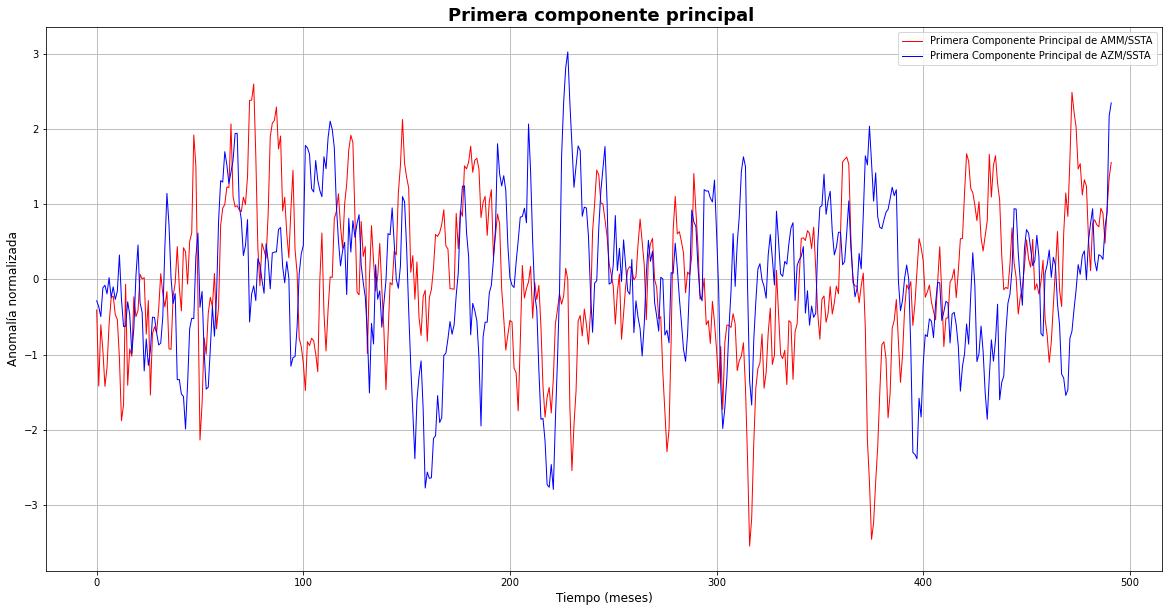

In [109]:
fig,ax=plt.subplots(figsize = (20,10))
ax.plot(np.arange(nt),(PCci),linewidth= 1,color='red',label='Primera Componente Principal de AMM/SSTA')
ax.plot(np.arange(nt),(PCchl),linewidth= 1,color='blue',label='Primera Componente Principal de AZM/SSTA')

ax.grid()
ax.legend()
ax.set_title('Primera componente principal ',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)

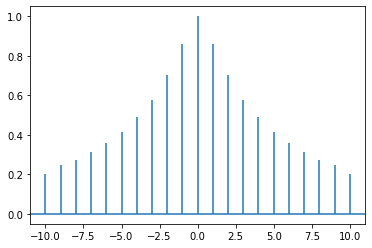

In [110]:
ar1=plt.acorr(PCci, usevlines=True, maxlags=10)

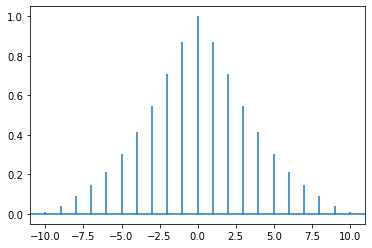

In [111]:
ar2=plt.acorr(PCchl, usevlines=True, maxlags=10)

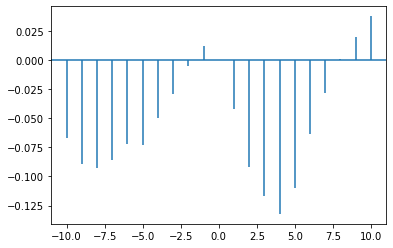

In [112]:
y2=stats.tsa.stattools.ccovf(PCchl,PCci)
y2
ar3=plt.xcorr(PCci,PCchl, detrend, usevlines=True, maxlags=10)

Text(0.5, 1.0, 'CrossCorrelation ')

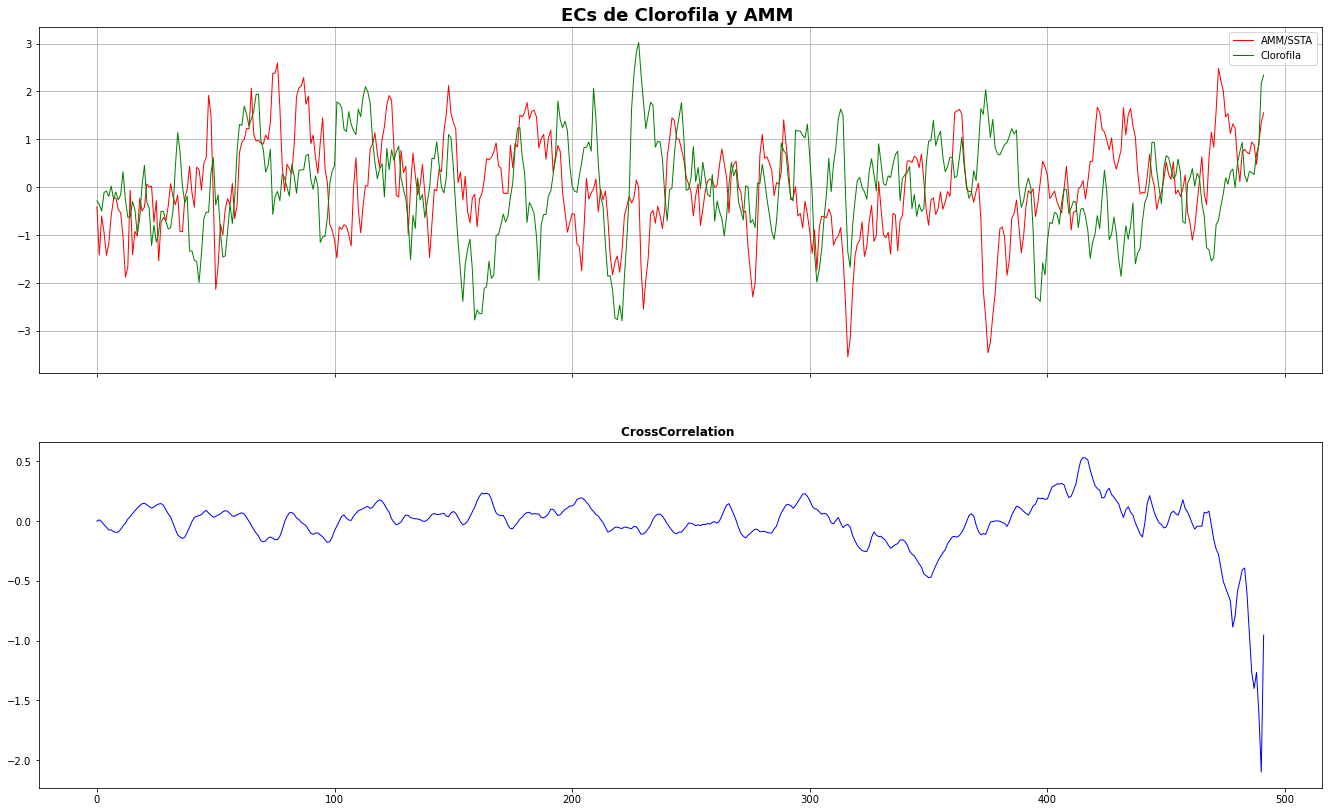

In [113]:
n1=signal.correlate(PCci,PCchl,method='fft')
n1.shape


fig,(ax,ax_fil)=plt.subplots(2, 1, sharex=True,figsize=(23,14))
ax.plot(np.arange(nt),(PCci),linewidth= 1,color='red',label='AMM/SSTA')
ax.plot(np.arange(nt),(PCchl),linewidth= 1,color='green',label='Clorofila')
ax_fil.plot(np.arange(nt),(y2),linewidth= 1,color='blue',label='CrossCorrelation')

ax.grid()
ax.legend()
ax.set_title('ECs de Clorofila y AMM ',fontsize=18,weight='bold')
ax_fil.set_title('CrossCorrelation ',fontsize=12,weight='bold')

In [114]:
!pip install seasonal

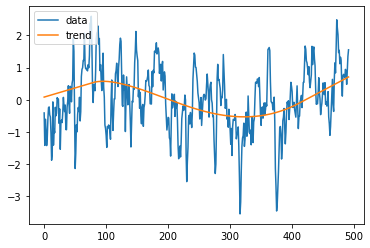

In [115]:
seasons, trend = fit_seasons(PCci)
trendPCci=trend



plt.figure()
plt.plot(PCci, label='data')
plt.plot(trend, label='trend')

plt.legend(loc='upper left')

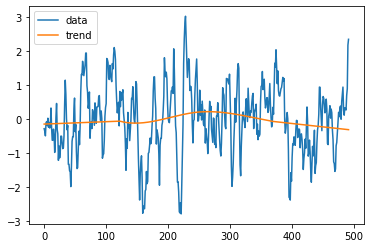

In [116]:
seasons, trend = fit_seasons(PCchl)
trendPCchl=trend

plt.figure()
plt.plot(PCchl, label='data')
plt.plot(trend, label='trend')

plt.legend(loc='upper left')

Text(0.5, 1.0, 'ECs de AZM y AMM ')

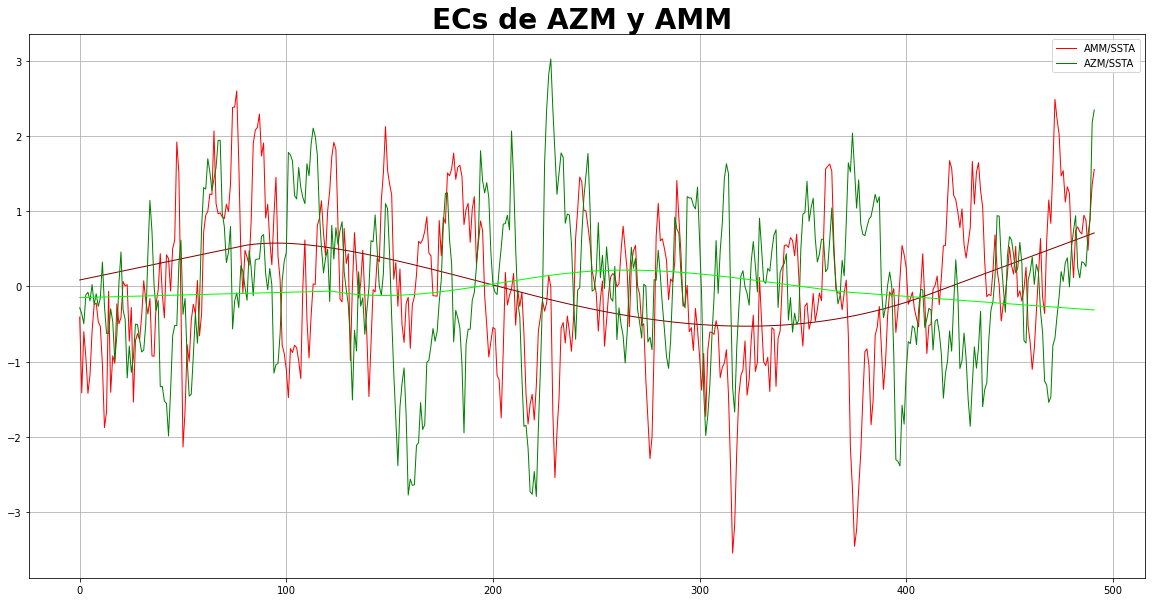

In [117]:
fig,ax=plt.subplots(figsize = (20,10))
ax.plot(np.arange(nt),PCci,linewidth= 1,color='red',label='AMM/SSTA')
ax.plot(np.arange(nt),trendPCci,linewidth= 1,color='maroon')
ax.plot(np.arange(nt),PCchl,linewidth= 1,color='green',label='AZM/SSTA')
ax.plot(np.arange(nt),trendPCchl,linewidth= 1,color='lime')


ax.grid()
ax.legend()
ax.set_title('ECs de AZM y AMM ',fontsize=28,weight='bold')



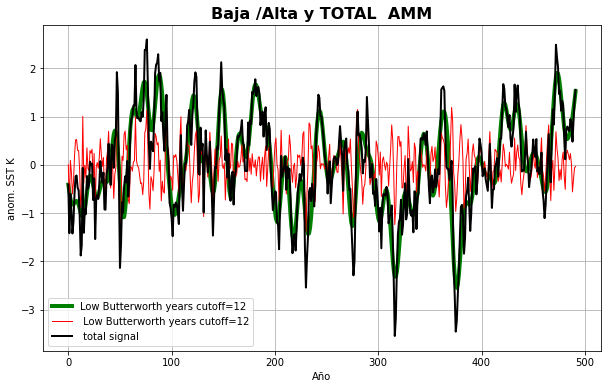

In [118]:
nt=492
nyc=12
n=10
Wn=1/6 #O FILTRANDO POR ESTACIONES f=1/3 Wn=2*f??
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
lowamm = signal.filtfilt(b,a,PCci)

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCci)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Baja /Alta y TOTAL  AMM',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom. SST K')
ax.plot(np.arange(nt),lowamm,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),PCci,linewidth= 2,color='black',label=' total signal')

ax.legend()
ax.grid()

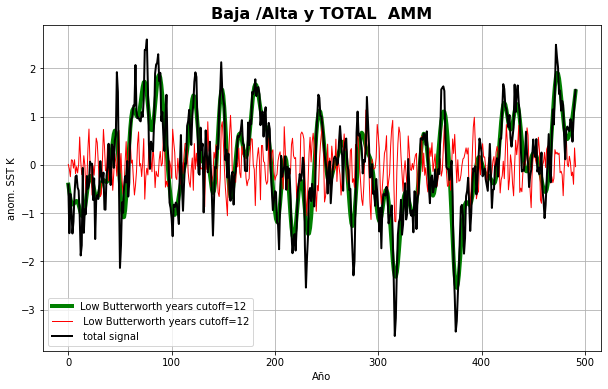

In [119]:
nyc=12
n=10
Wn=1/6 #O FILTRANDO POR ESTACIONES f=1/3 Wn=2*f??
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
lowamm = signal.filtfilt(b,a,PCci)

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCchl)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Baja /Alta y TOTAL  AMM',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom. SST K')
ax.plot(np.arange(nt),lowamm,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),PCci,linewidth= 2,color='black',label=' total signal')

ax.legend()
ax.grid()

In [120]:
nm=3
nyears=21
nt=nm*nyears


<ipython-input-121-1f0ccb903f86>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')


(120, 5)

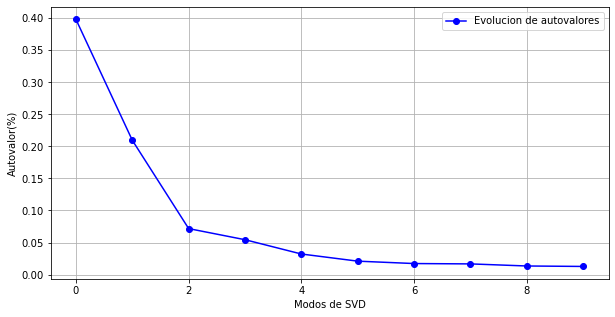

In [121]:
AT=AT_ver
C=np.dot(np.transpose(AT),AT)
C.shape

eof,d,eof2=linalg.svd(C)
d.shape
fvar=(d)/sum(d)

sum(fvar[:2])

fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.xlabel('Modos de SVD')
plt.ylabel('Autovalor(%)')
plt.legend()
plt.grid()

#Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así 
#que no se transpone
PC=np.dot(AT,eof[:,:5])
#calculamos las anomalías estandarizadas 

#PC=PC.reshape(nyears*nm,5)

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

Text(0.5, 1.0, 'VERANO EC2 ')

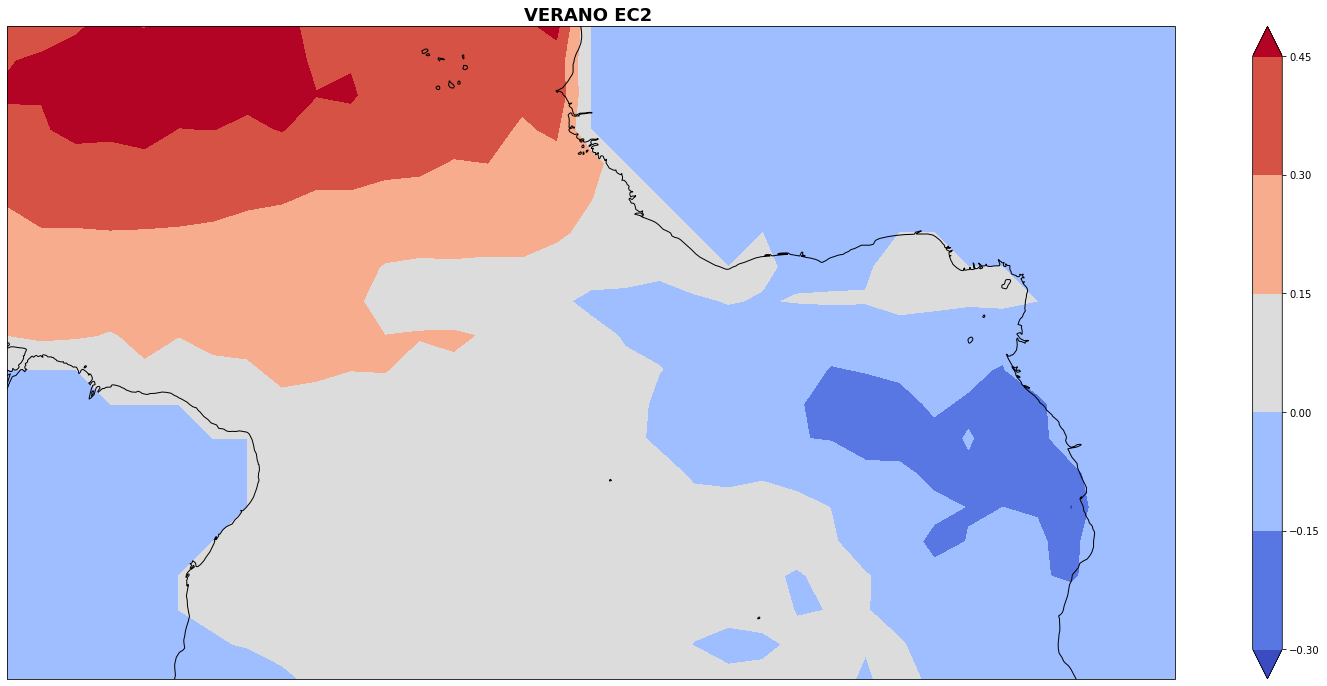

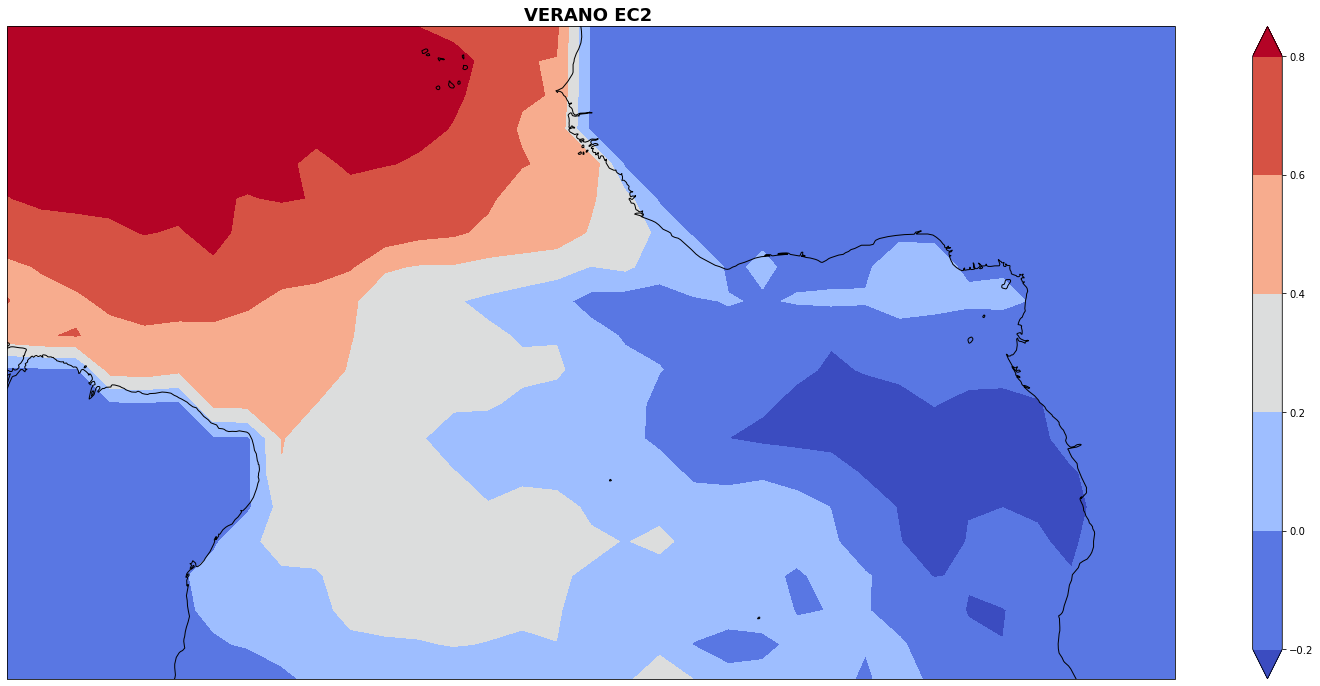

In [122]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,1]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC2 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC2 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'VERANO EC1 ')

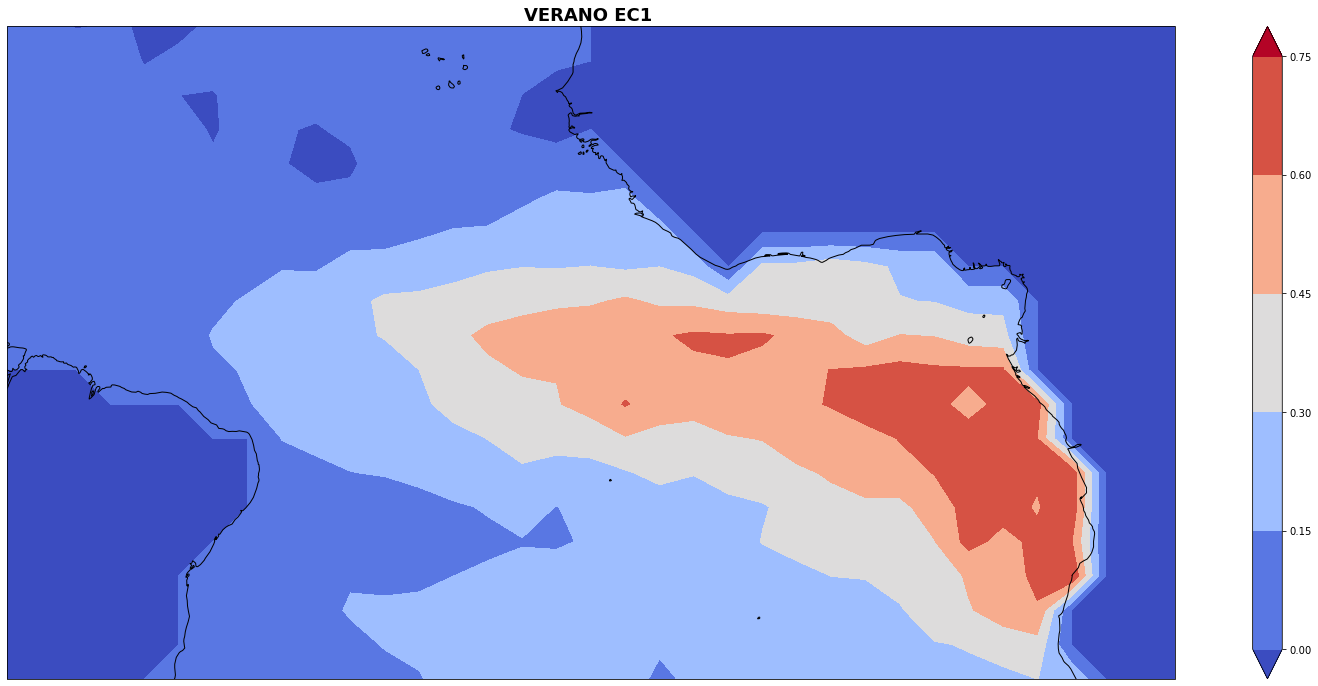

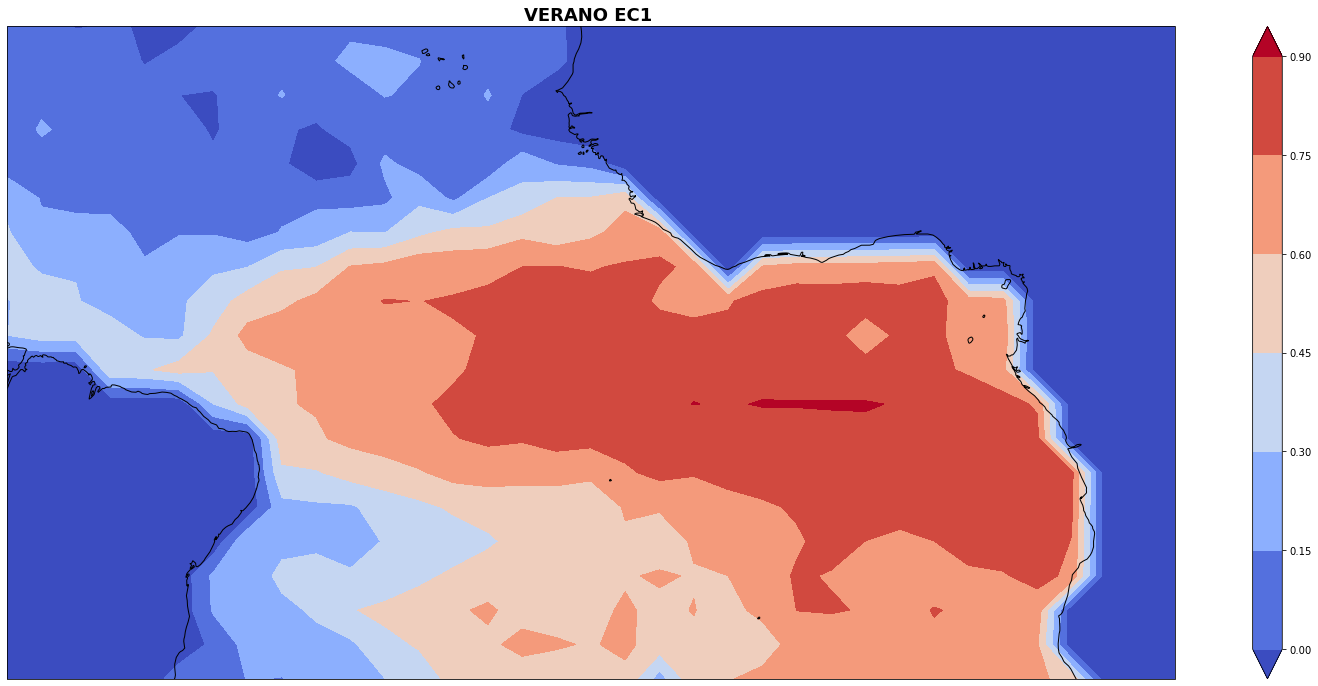

In [123]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,0]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC1 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC1 ',fontsize=18,weight='bold')

<ipython-input-124-ae76957a19cf>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')


(120, 5)

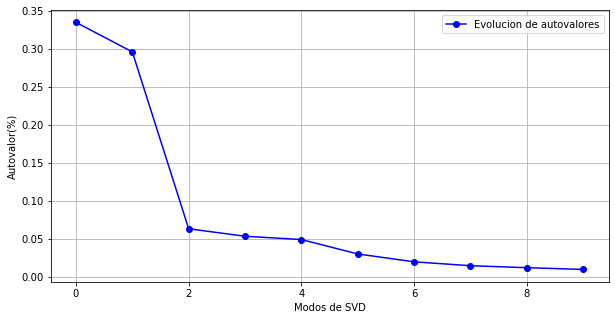

In [124]:
AT=AT_pri
C=np.dot(np.transpose(AT),AT)
C.shape

eof,d,eof2=linalg.svd(C)
d.shape
fvar=(d)/sum(d)

sum(fvar[:2])

fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.xlabel('Modos de SVD')
plt.ylabel('Autovalor(%)')
plt.legend()
plt.grid()

#Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así 
#que no se transpone
PC=np.dot(AT,eof[:,:5])
#calculamos las anomalías estandarizadas 

#PC=PC.reshape(nyears*nm,5)

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

Text(0.5, 1.0, 'PRIMAVERA EC2 ')

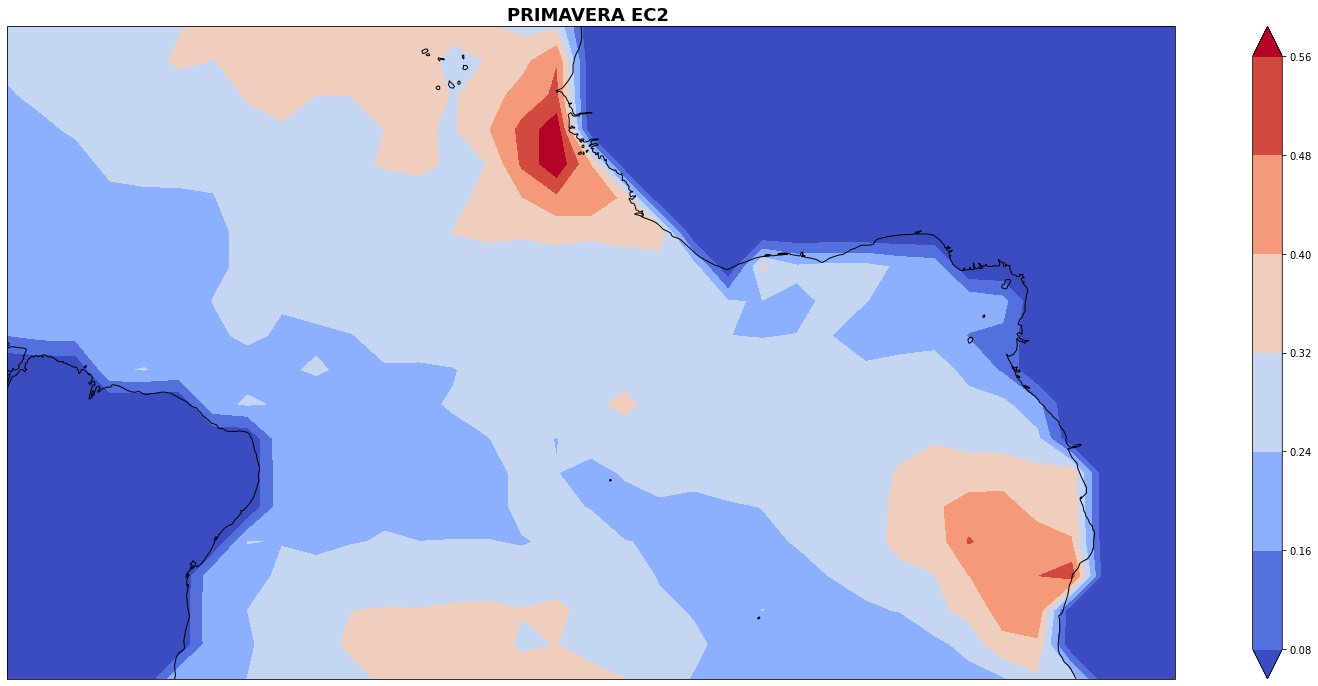

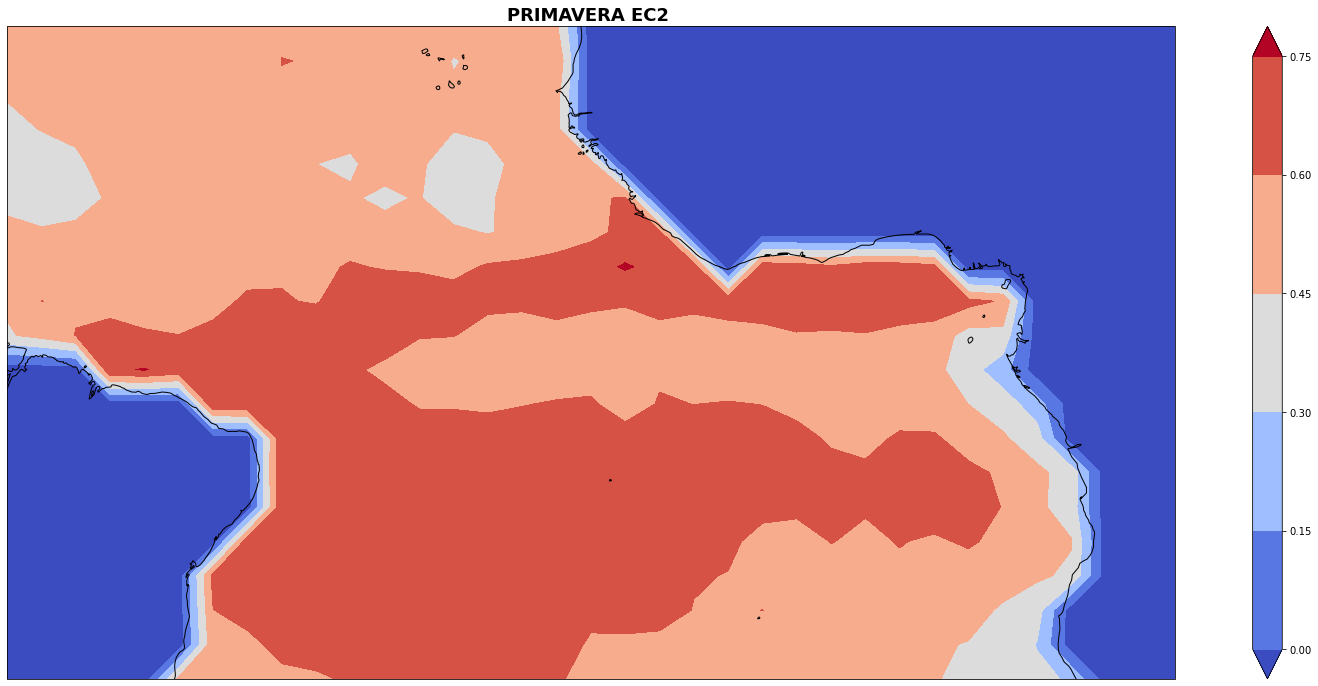

In [125]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,1]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC2 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC2 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'PRIMAVERA EC1 ')

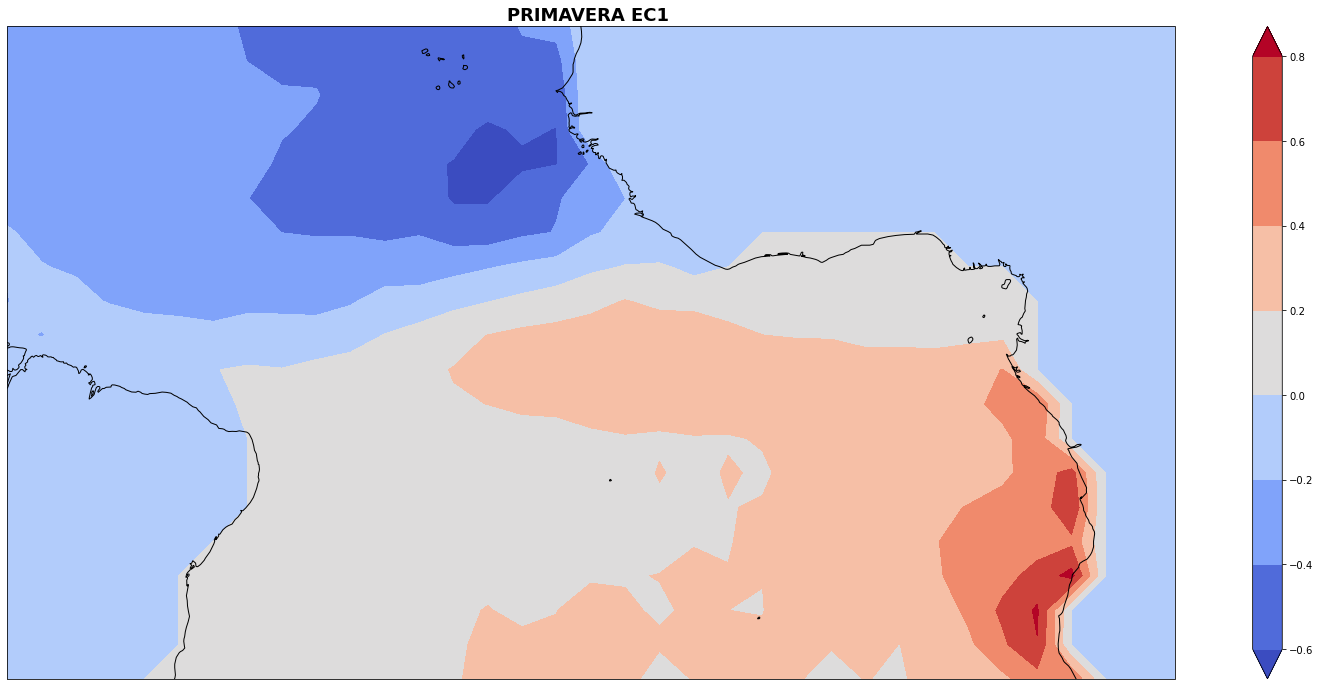

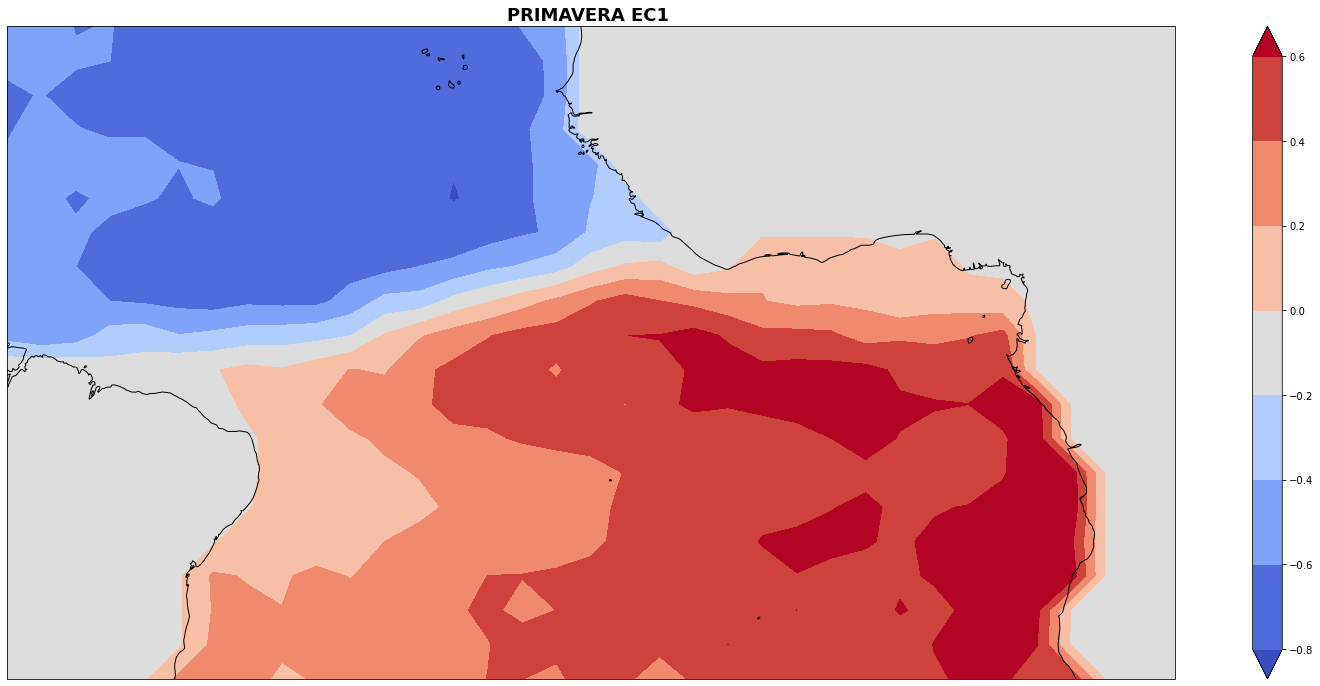

In [126]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,0]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC1 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC1 ',fontsize=18,weight='bold')

<ipython-input-127-b31465e138b8>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')


(120, 5)

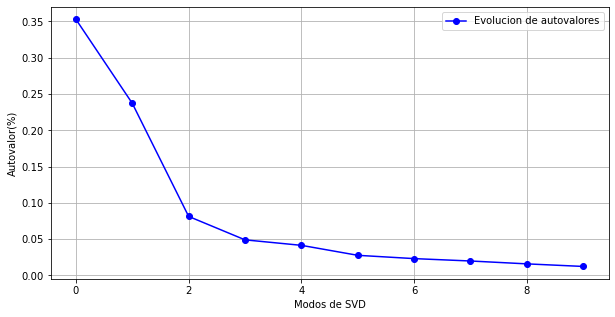

In [127]:
AT=AT_inv
C=np.dot(np.transpose(AT),AT)
C.shape

eof,d,eof2=linalg.svd(C)
d.shape
fvar=(d)/sum(d)

sum(fvar[:2])

fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.xlabel('Modos de SVD')
plt.ylabel('Autovalor(%)')
plt.legend()
plt.grid()

#Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así 
#que no se transpone
PC=np.dot(AT,eof[:,:5])
#calculamos las anomalías estandarizadas 

#PC=PC.reshape(nyears*nm,5)

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

Text(0.5, 1.0, 'INVIERNO EC2 ')

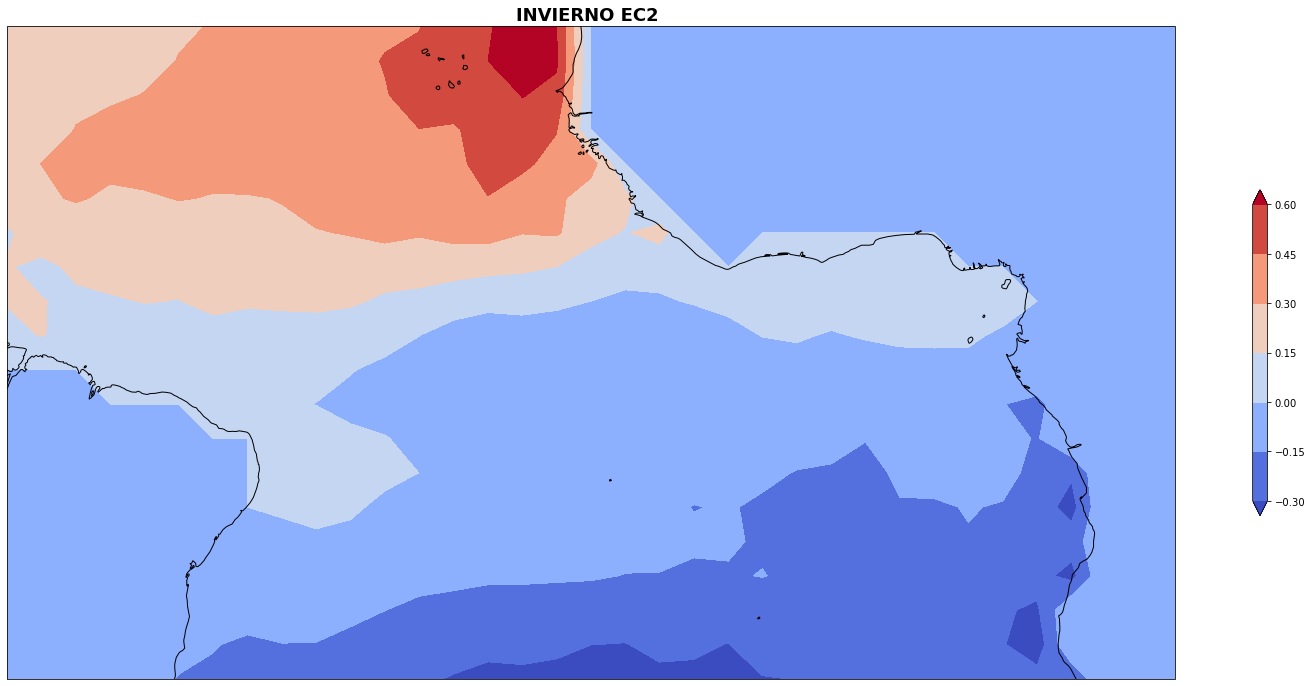

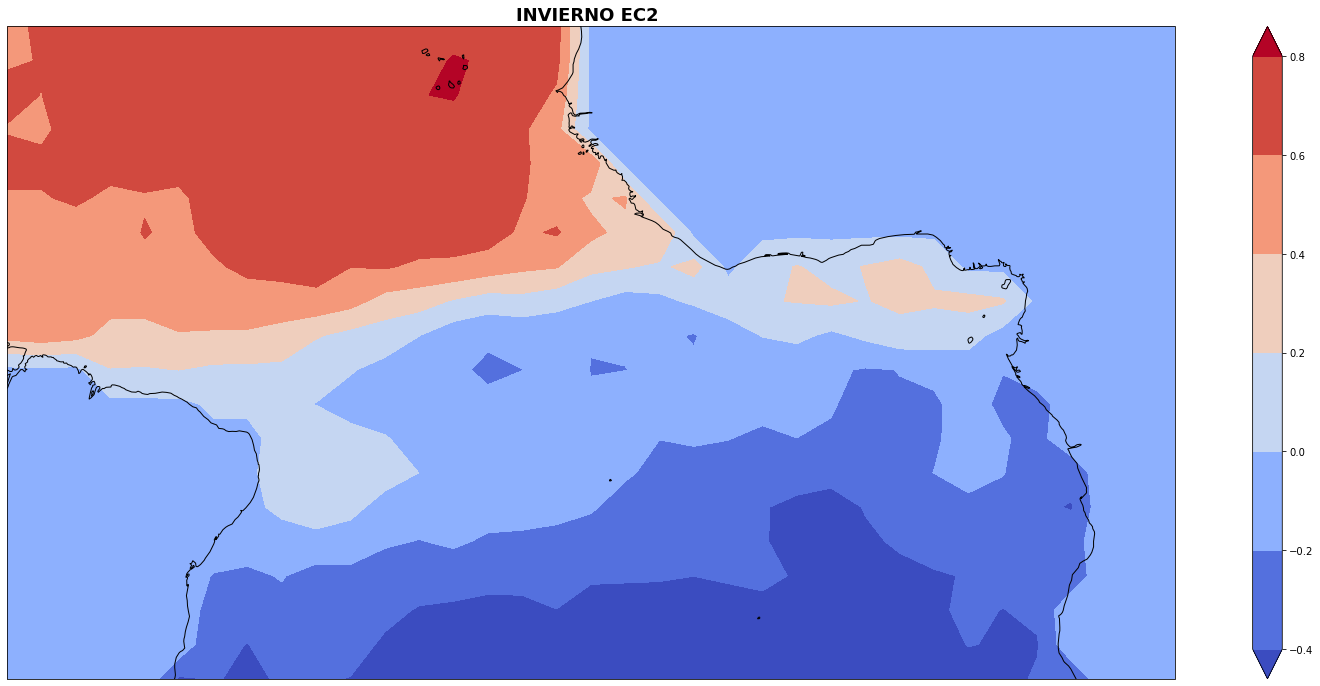

In [128]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,1]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,shrink=0.5) #Para la barra de colores
ax.set_title('INVIERNO EC2 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('INVIERNO EC2 ',fontsize=18,weight='bold')

In [129]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,0]),0.01)

fig = plt.subplot(1,3) 
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax1.coastlines()
fig.colorbar(im,ax11=ax) #Para la barra de colores
ax1.set_title('INVIERNO EC1 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax2.coastlines()
fig.colorbar(im,ax22=ax) #Para la barra de colores
ax.set_title('INVIERNO EC1 ',fontsize=18,weight='bold')

Y=AT_a[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax3.coastlines()
fig.colorbar(im,ax33=ax) #Para la barra de colores
ax.set_title('AMM ABRIL 2009 hPa',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/niñadakarssttotalabril.png')

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 432x288 with 0 Axes>

In [ ]:
AT=AT_oto
C=np.dot(np.transpose(AT),AT)
C.shape

eof,d,eof2=linalg.svd(C)
d.shape
fvar=(d)/sum(d)

sum(fvar[:2])

fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.xlabel('Modos de SVD')
plt.ylabel('Autovalor(%)')
plt.legend()
plt.grid()

#Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así 
#que no se transpone
PC=np.dot(AT,eof[:,:5])
#calculamos las anomalías estandarizadas 

#PC=PC.reshape(nyears*nm,5)

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

PCs.shape

In [ ]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,1]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OTOÑO EC2 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OTOÑO EC2 CORR ',fontsize=18,weight='bold')

In [ ]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCs[:,0]),0.01)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OTOÑO EC1 ',fontsize=18,weight='bold')


fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OTOÑO EC2 CORR',fontsize=18,weight='bold')

In [ ]:
#FENÓMENO DE NIÑA DAKAR QUE EVOLUCIONA HACIA UN MODO MERIDIONAL FUERTE (NOVIEMBRE 2008-JUNIO 2009)

In [ ]:
Y=AT_n[yrs==2008]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM NOVIEMBRE 2008',fontsize=18,weight='bold')

In [ ]:
Y=AT_d[yrs==2008]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM DICIEMBRE 2008',fontsize=18,weight='bold')

In [ ]:

Y=AT_e[yrs==2009]

fig,ax = plt.subplot(1,4,figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM ENERO 2009',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/niñadakarssttotalenero.png')

In [ ]:
Y=AT_f[yrs==2009]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM FEBRERO 2009 ',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/niñadakarssttotalfebrero.png')
Y=AT_m[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM MARZO 2009 ',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/niñadakarssttotalmarzo.png')

In [ ]:
Y=AT_m[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM MARZO 2009 ',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/niñadakarssttotalmarzo.png')

In [ ]:
Y=AT_a[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM ABRIL 2009 hPa',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/niñadakarssttotalabril.png')

In [ ]:
Y=AT_y[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AMM MAYO 2009 hPa',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/niñadakarssttotalmayo.png')

In [ ]:
grid

In [ ]:
Y=[AT_f,AT_m,AT_a]
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for ax in grid:
    im = ax.contourf(lon_AT,lat_AT,Y[i].reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

In [ ]:
gs=gridspec.GridSpec(1,3)
Y=AT_f[yrs==2011] 
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()#Para la barra de colores
ax.set_title(' FEBRERO  ',fontsize=10,weight='bold')
fig.colorbar(im,ax=ax) 

Y=AT_m[yrs==2011]
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(0))
im = ax1.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())

ax1.coastlines()
 #Para la barra de colores
ax1.set_title(' MARZO ',fontsize=10,weight='bold')
fig.colorbar(im,ax1=ax1) 

Y=AT_a[yrs==2011]

ax2 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree(0))
im = ax2.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax2.coastlines()
ax2.set_title(' ABRIL ',fontsize=10,weight='bold')
fig.colorbar(im,ax2=ax2) 

In [ ]:
Y=AT_y[yrs==2012]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMMAYO 2011 hPa',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/benguelassttotalmayo.png')

Y=AT_j[yrs==2011]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMJUNIO 2011 ',fontsize=18,weight='bold')
fig.savefig('C:/Users/Miguel/TFG/fotostfg/benguelassttotaljunio.png')

Y=AT_l[yrs==2011]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMJULIO 2011 ',fontsize=18,weight='bold')

Y=AT_u[yrs==2011]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMAGOSTO 2011 ',fontsize=18,weight='bold')

Y=AT_s[yrs==2011]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMSEPTIEMBRE 2011 ',fontsize=18,weight='bold')

In [ ]:

Y=AT_m[yrs==2019]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMMARZO 2019 hPa',fontsize=18,weight='bold')

Y=AT_a[yrs==2019]
fig = plt.figure(figsize=(28,12)) 
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax1.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax1.coastlines()
fig.colorbar(im,ax1=ax1) #Para la barra de colores
ax.set_title('AZMABRIL 2019 hPa',fontsize=18,weight='bold')
Y=AT_y[yrs==2019]
fig = plt.figure(figsize=(28,12)) 
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMMAYO 2019 hPa',fontsize=18,weight='bold')

Y=AT_j[yrs==2019]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMJUNIO 2019 ',fontsize=18,weight='bold')

Y=AT_l[yrs==2019]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMJULIO 2019 ',fontsize=18,weight='bold')

Y=AT_u[yrs==2019]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMAGOSTO 2019 ',fontsize=18,weight='bold')

Y=AT_s[yrs==2019]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('AZMSEPTIEMBRE 2019 ',fontsize=18,weight='bold')